# K-means Clustering

### Prompt:
Random sample of 30,000 U.S. high-school students who had profiles on a well-known Social Networking Site (SNS) in 2006. 

Data sampled evenly across 4 high-school graduation years, 2006 through 2009.

Using an automated web-crawler the full text of the SNS profiles were extracted along with the following demographic variables: 

- graduation year
- age
- gender
- number of SNS friends

From the top 500 words found on the students' pages, 36 words were chosen to represent 5 categories of interests: extracurricular activities, fashion, romance, religion, and anti-social behavior. These 36 words contain terms such as basketball, sexy, kissed, bible, shopping, death, and drugs. The final dataset indicates the demographic variables for each person as well as the number of times each word appeared on each student's profile.

Data compiled by Brett Lantz while conducting sociological research at University of Notre Dame.

Resources used:<br>
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html<br>
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html<br>
https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f

In [1]:
# linear algebra
import pandas as pd
import numpy as np
import random

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, MinMaxScaler, StandardScaler

# K-means clustering
from scipy import stats
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans

# Decision tree
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.tree import plot_tree

# Exporting results
import graphviz
import imageio
import pydotplus
import io

# Miscellaneous
from kneed import KneeLocator # find elbow
import pyreadr # import R data

In [2]:
# Import R data as ordered dict
data = pyreadr.read_r("C:/Users/chely/Documents/Fall 2/Data Mining/Data/TeenSNS.RData")

# Extract df from data and save
df = data['teens']

# Remove existing cluster column
df = df[df.columns.difference(['cluster'])]

In [3]:
df.head()

,abercrombie,age,band,baseball,basketball,bible,blonde,cheerleading,church,clothes,...,rock,sex,sexy,shopping,soccer,softball,sports,swimming,tennis,volleyball
0,0,18.982,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,18.801,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
2,0,18.335,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,18.875,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,18.995,1,0,0,0,0,0,0,0,...,0,1,0,2,0,0,0,0,0,0


In [4]:
# list of 37 terms used in status updates by teens
terms = ["friends", "basketball", "football", "soccer", "softball", "volleyball", "swimming", "cheerleading",
         "baseball", "tennis", "sports", "cute", "sex", "sexy", "hot", "kissed", "dance", "band", "marching",
          "music", "rock", "god", "church", "jesus", "bible", "hair", "dress", "blonde", "mall", "shopping",
          "clothes", "hollister", "abercrombie", "die", "death", "drunk", "drugs"]

# Demographic attributes
demographics = ["gradyear", "gender", "age", "female", "no_gender"]

### Initial EDA

In [5]:
# Only include observations where the sum of all the terms per teen is greater than 0 (remove obs with no terms)
df = df[df[terms].sum(axis=1)>0]

# Get dims: 29074 rows, 43 cols
print("Data Dimension:", df.shape)

# basic summary stats for the terms
df.describe()

Data Dimension: (29074, 42)


,abercrombie,age,band,baseball,basketball,bible,blonde,cheerleading,church,clothes,...,rock,sex,sexy,shopping,soccer,softball,sports,swimming,tennis,volleyball
count,29074.000000,29074.000000,29074.000000,29074.000000,29074.000000,29074.000000,29074.000000,29074.000000,29074.000000,29074.000000,...,29074.000000,29074.000000,29074.000000,29074.000000,29074.000000,29074.000000,29074.000000,29074.000000,29074.000000,29074.000000
mean,0.052796,17.228350,0.309142,0.108275,0.275848,0.022013,0.102084,0.110030,0.256071,0.153230,...,0.251083,0.216069,0.145697,0.364243,0.229862,0.166334,0.144425,0.138681,0.090115,0.147692
std,0.283821,1.141004,1.135165,0.529628,0.815985,0.207843,1.972928,0.522102,0.846011,0.479353,...,0.730426,1.140624,0.535944,0.733048,0.930843,0.750826,0.477851,0.524593,0.524890,0.649536
min,0.000000,13.027000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,16.268000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,17.227000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,18.193000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.000000,19.995000,66.000000,16.000000,24.000000,11.000000,327.000000,9.000000,44.000000,8.000000,...,21.000000,114.000000,18.000000,11.000000,27.000000,17.000000,12.000000,31.000000,15.000000,14.000000


In [6]:
# Set random seed for reproducibility
np.random.seed(7515)

# Get 5000 random indices from 1 to 29074 to downsample obs to 5000 because 30K is a lot to draw
sample = df.iloc[random.sample(range(29074), 5000)]

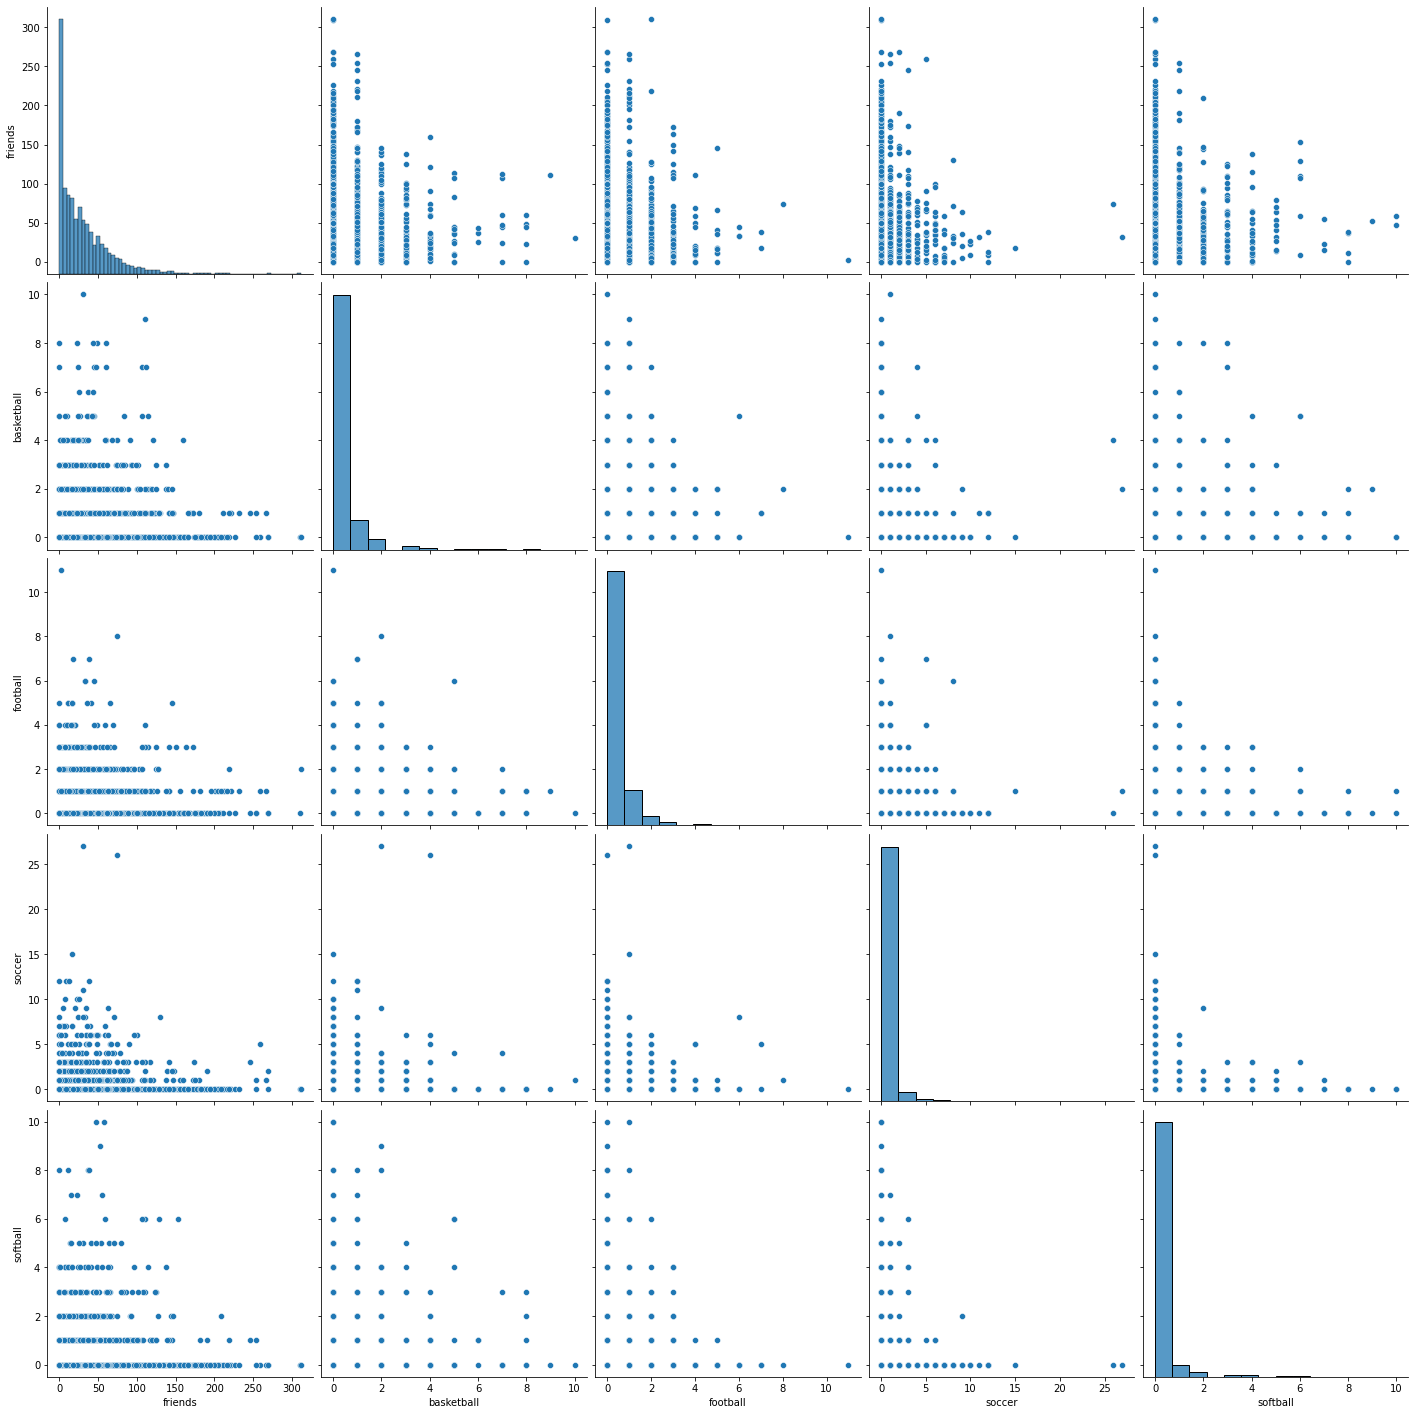

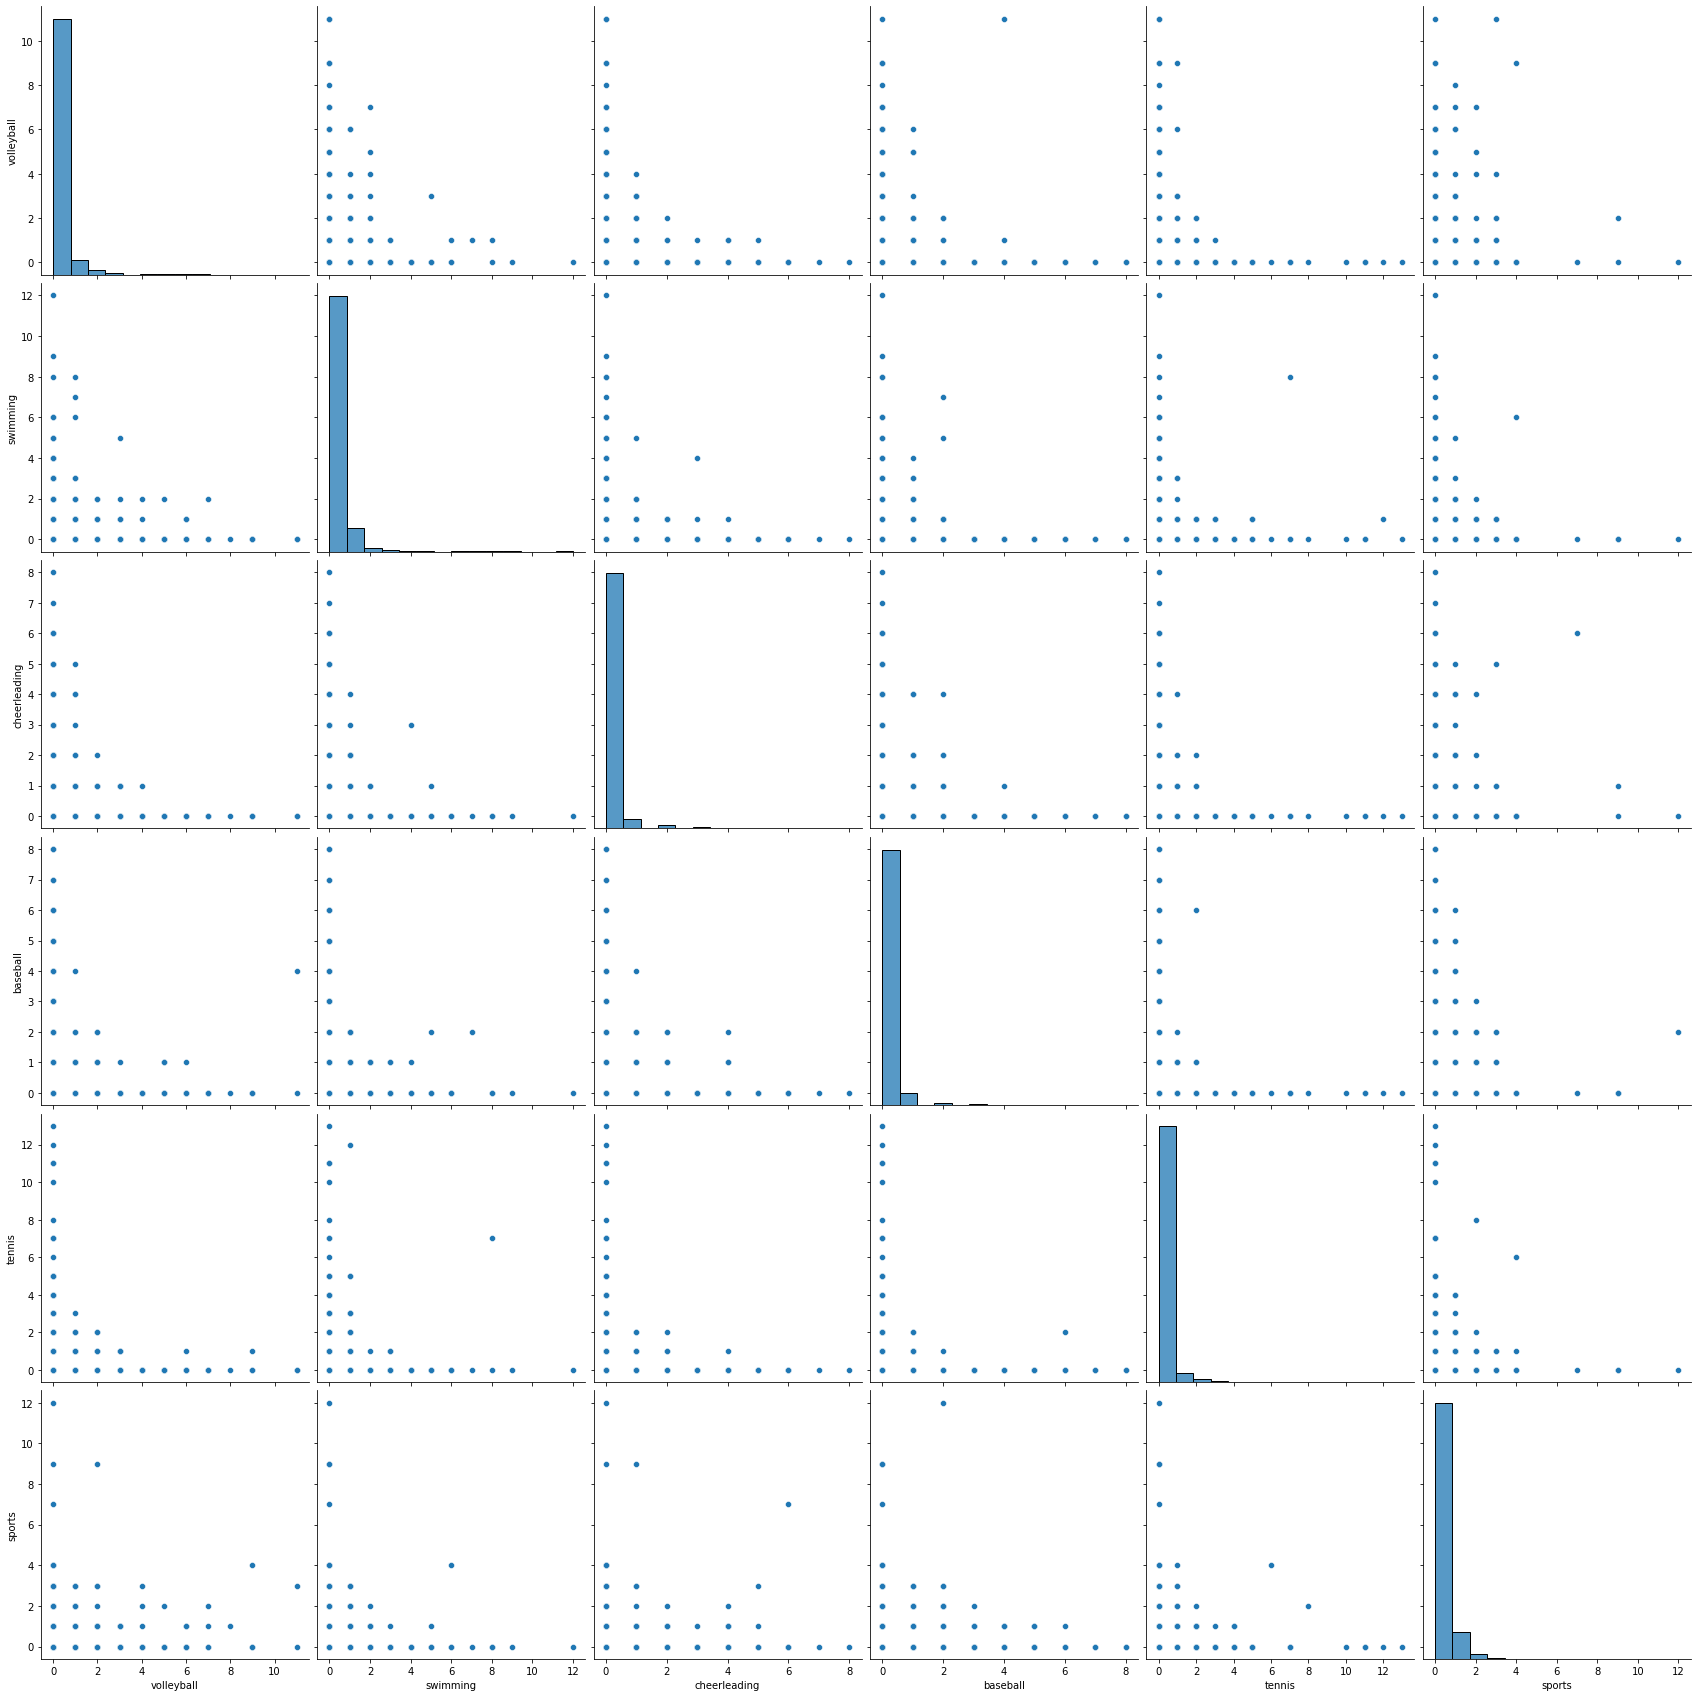

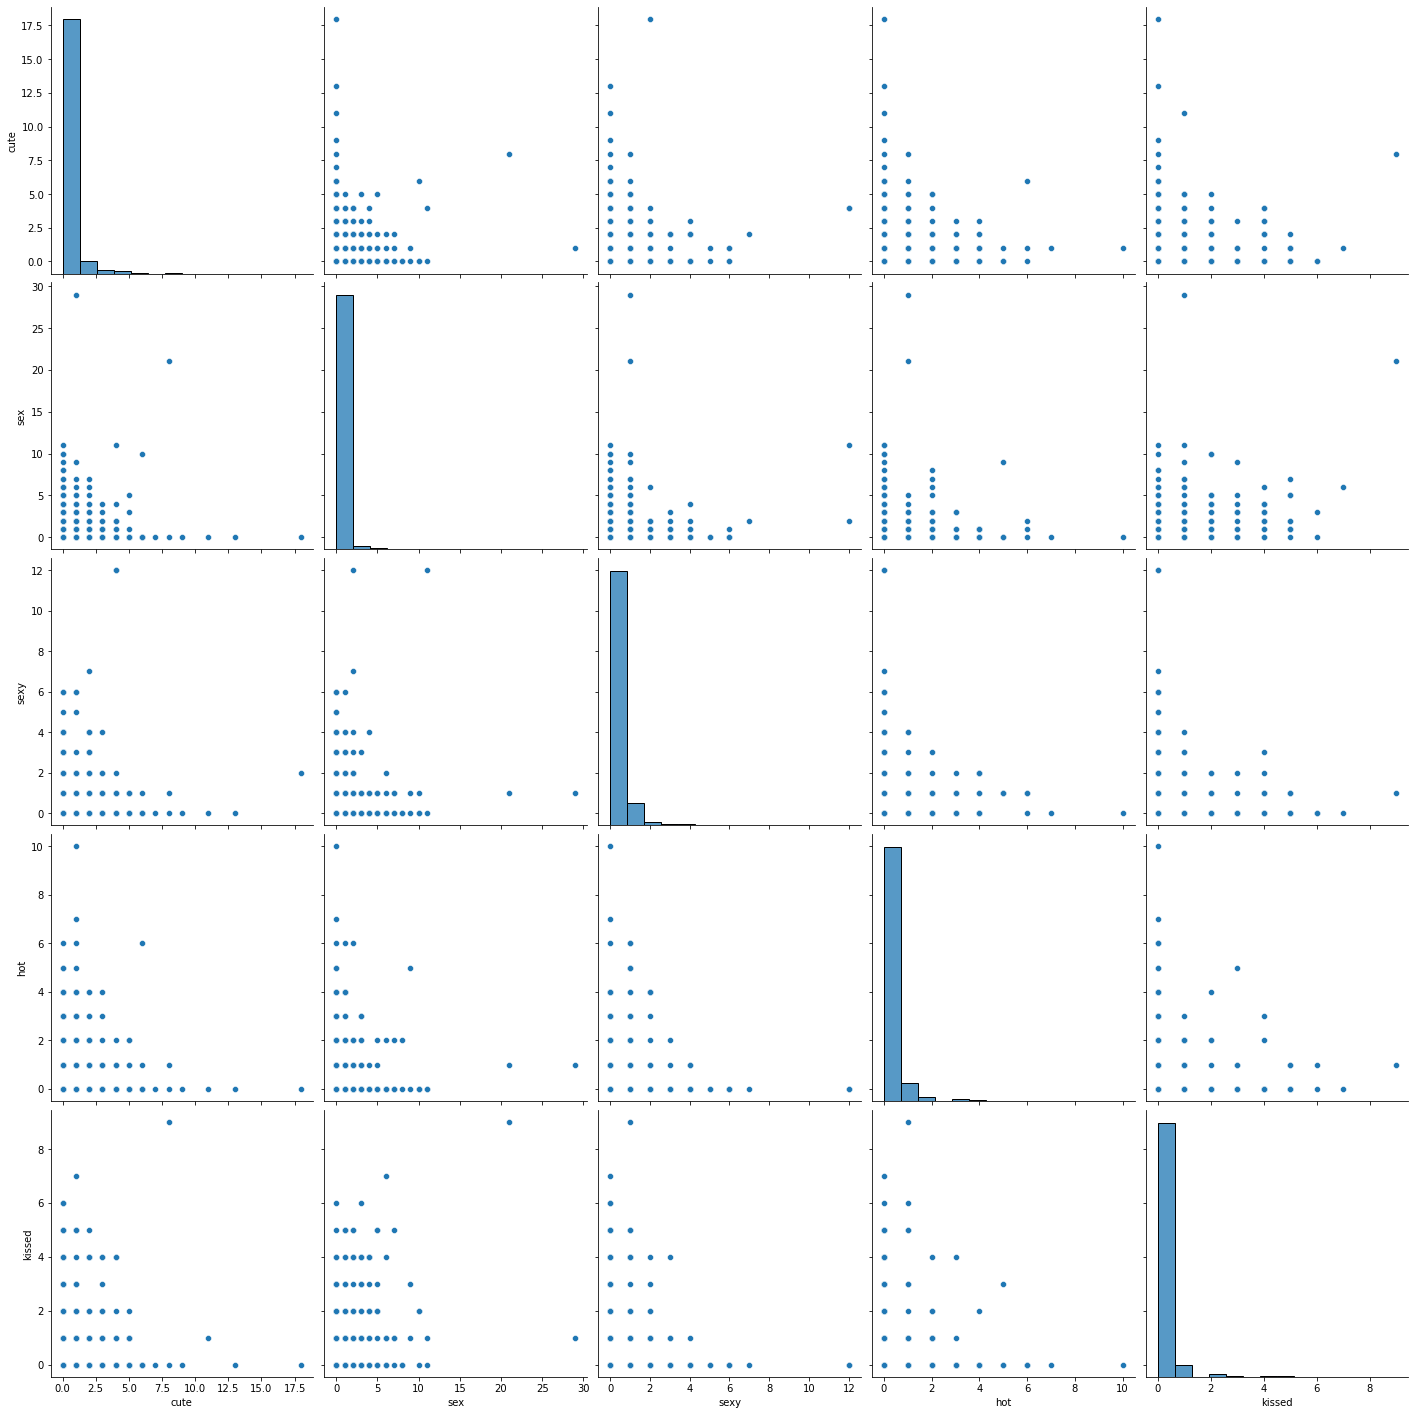

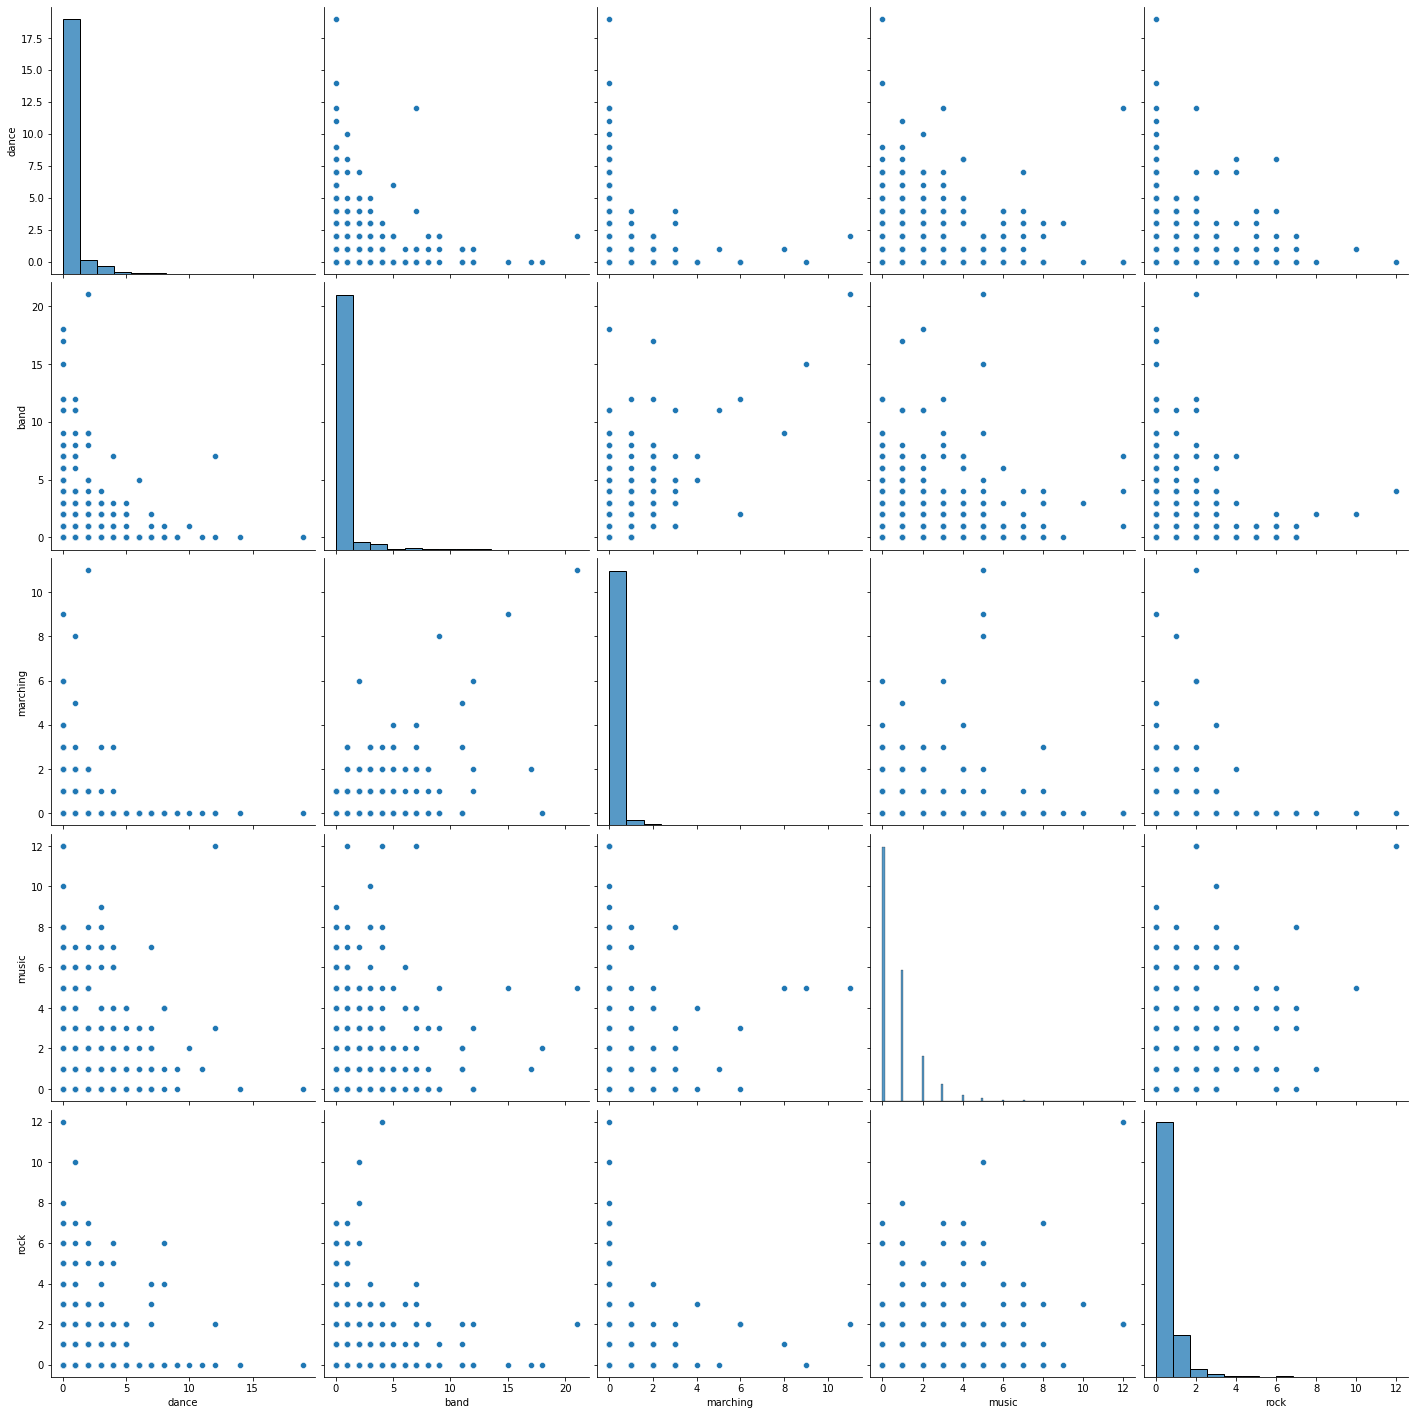

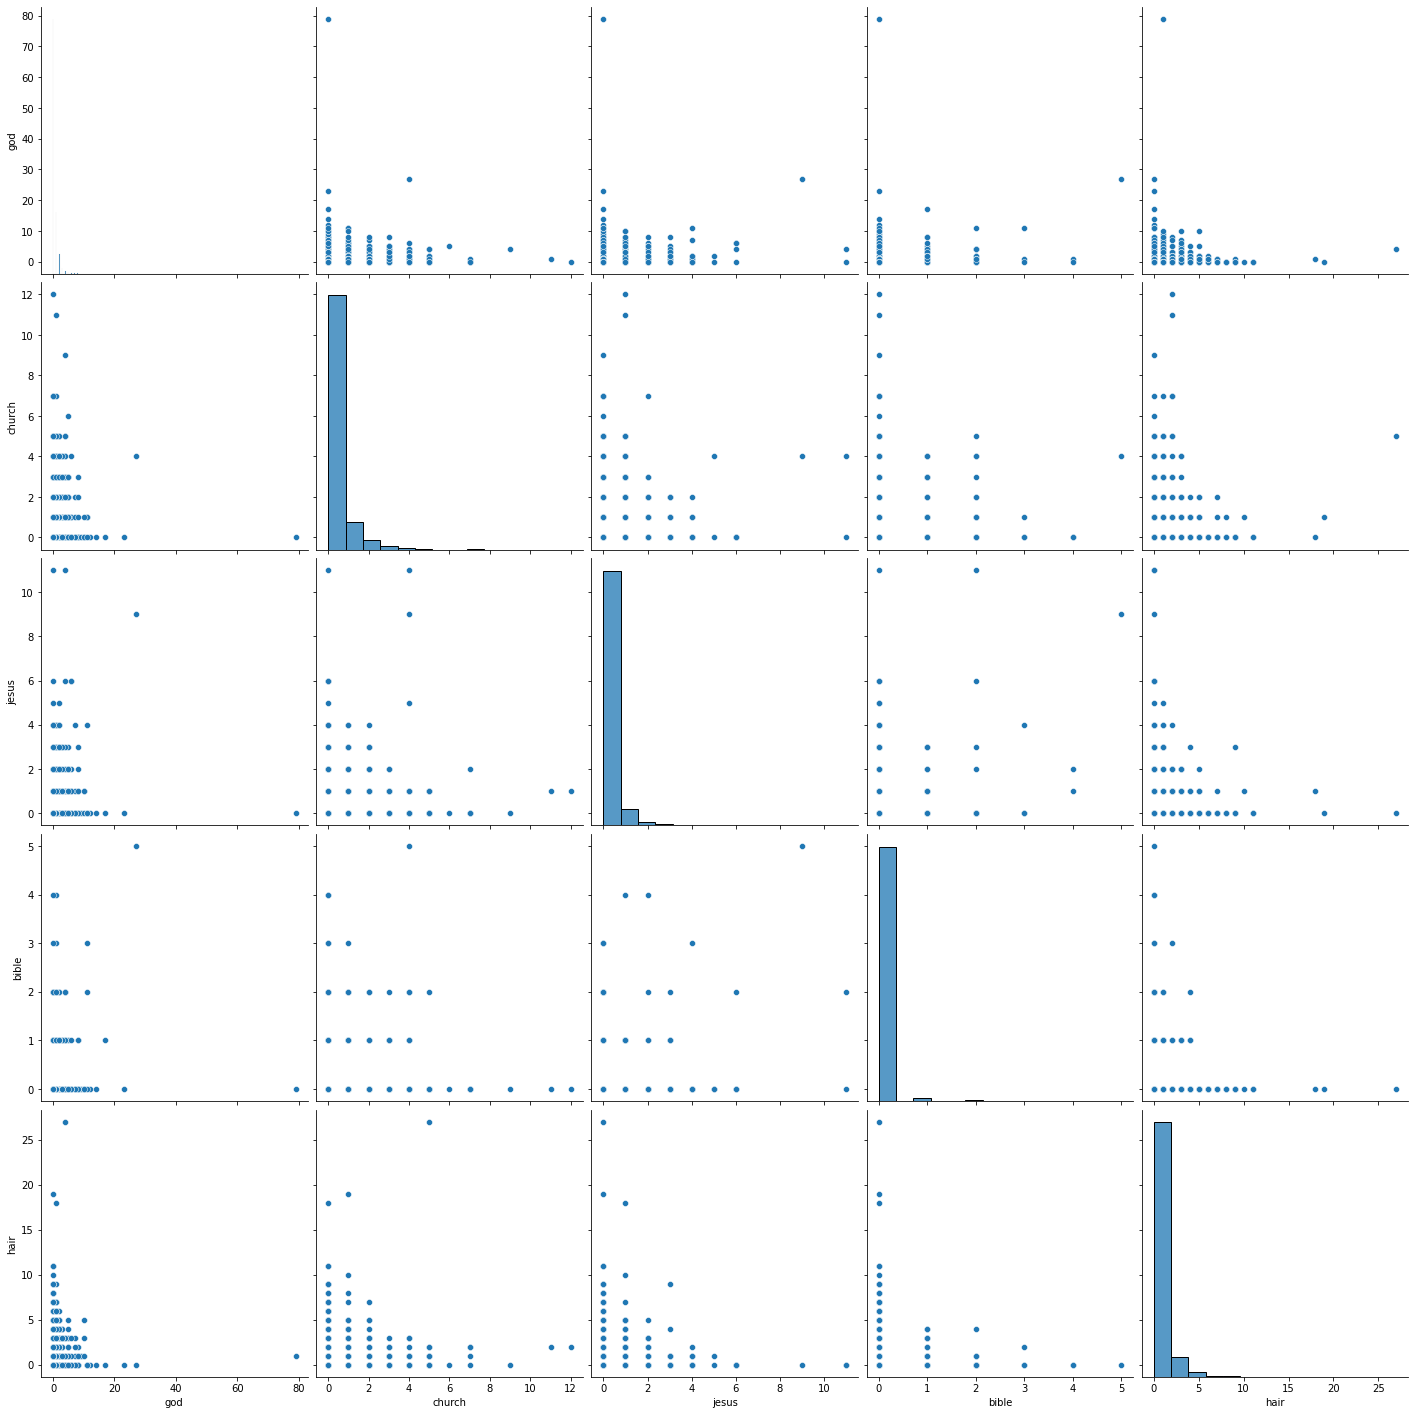

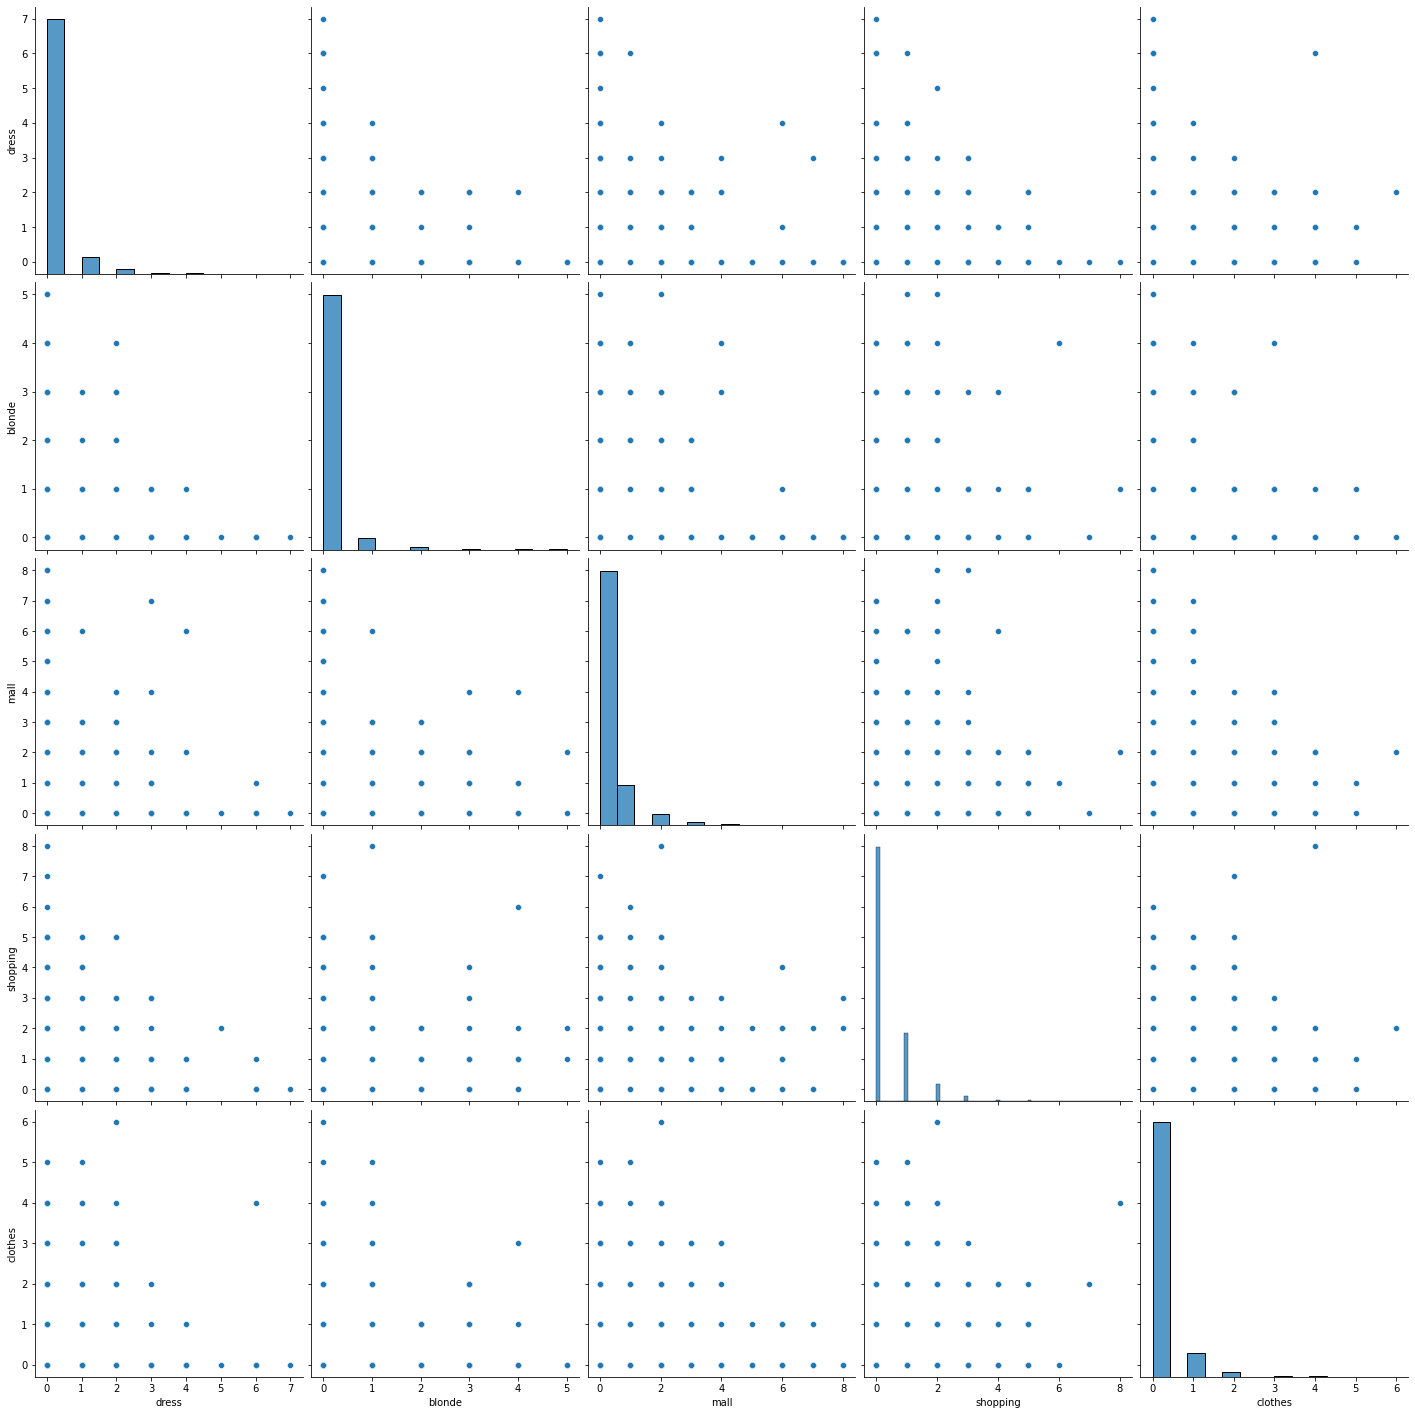

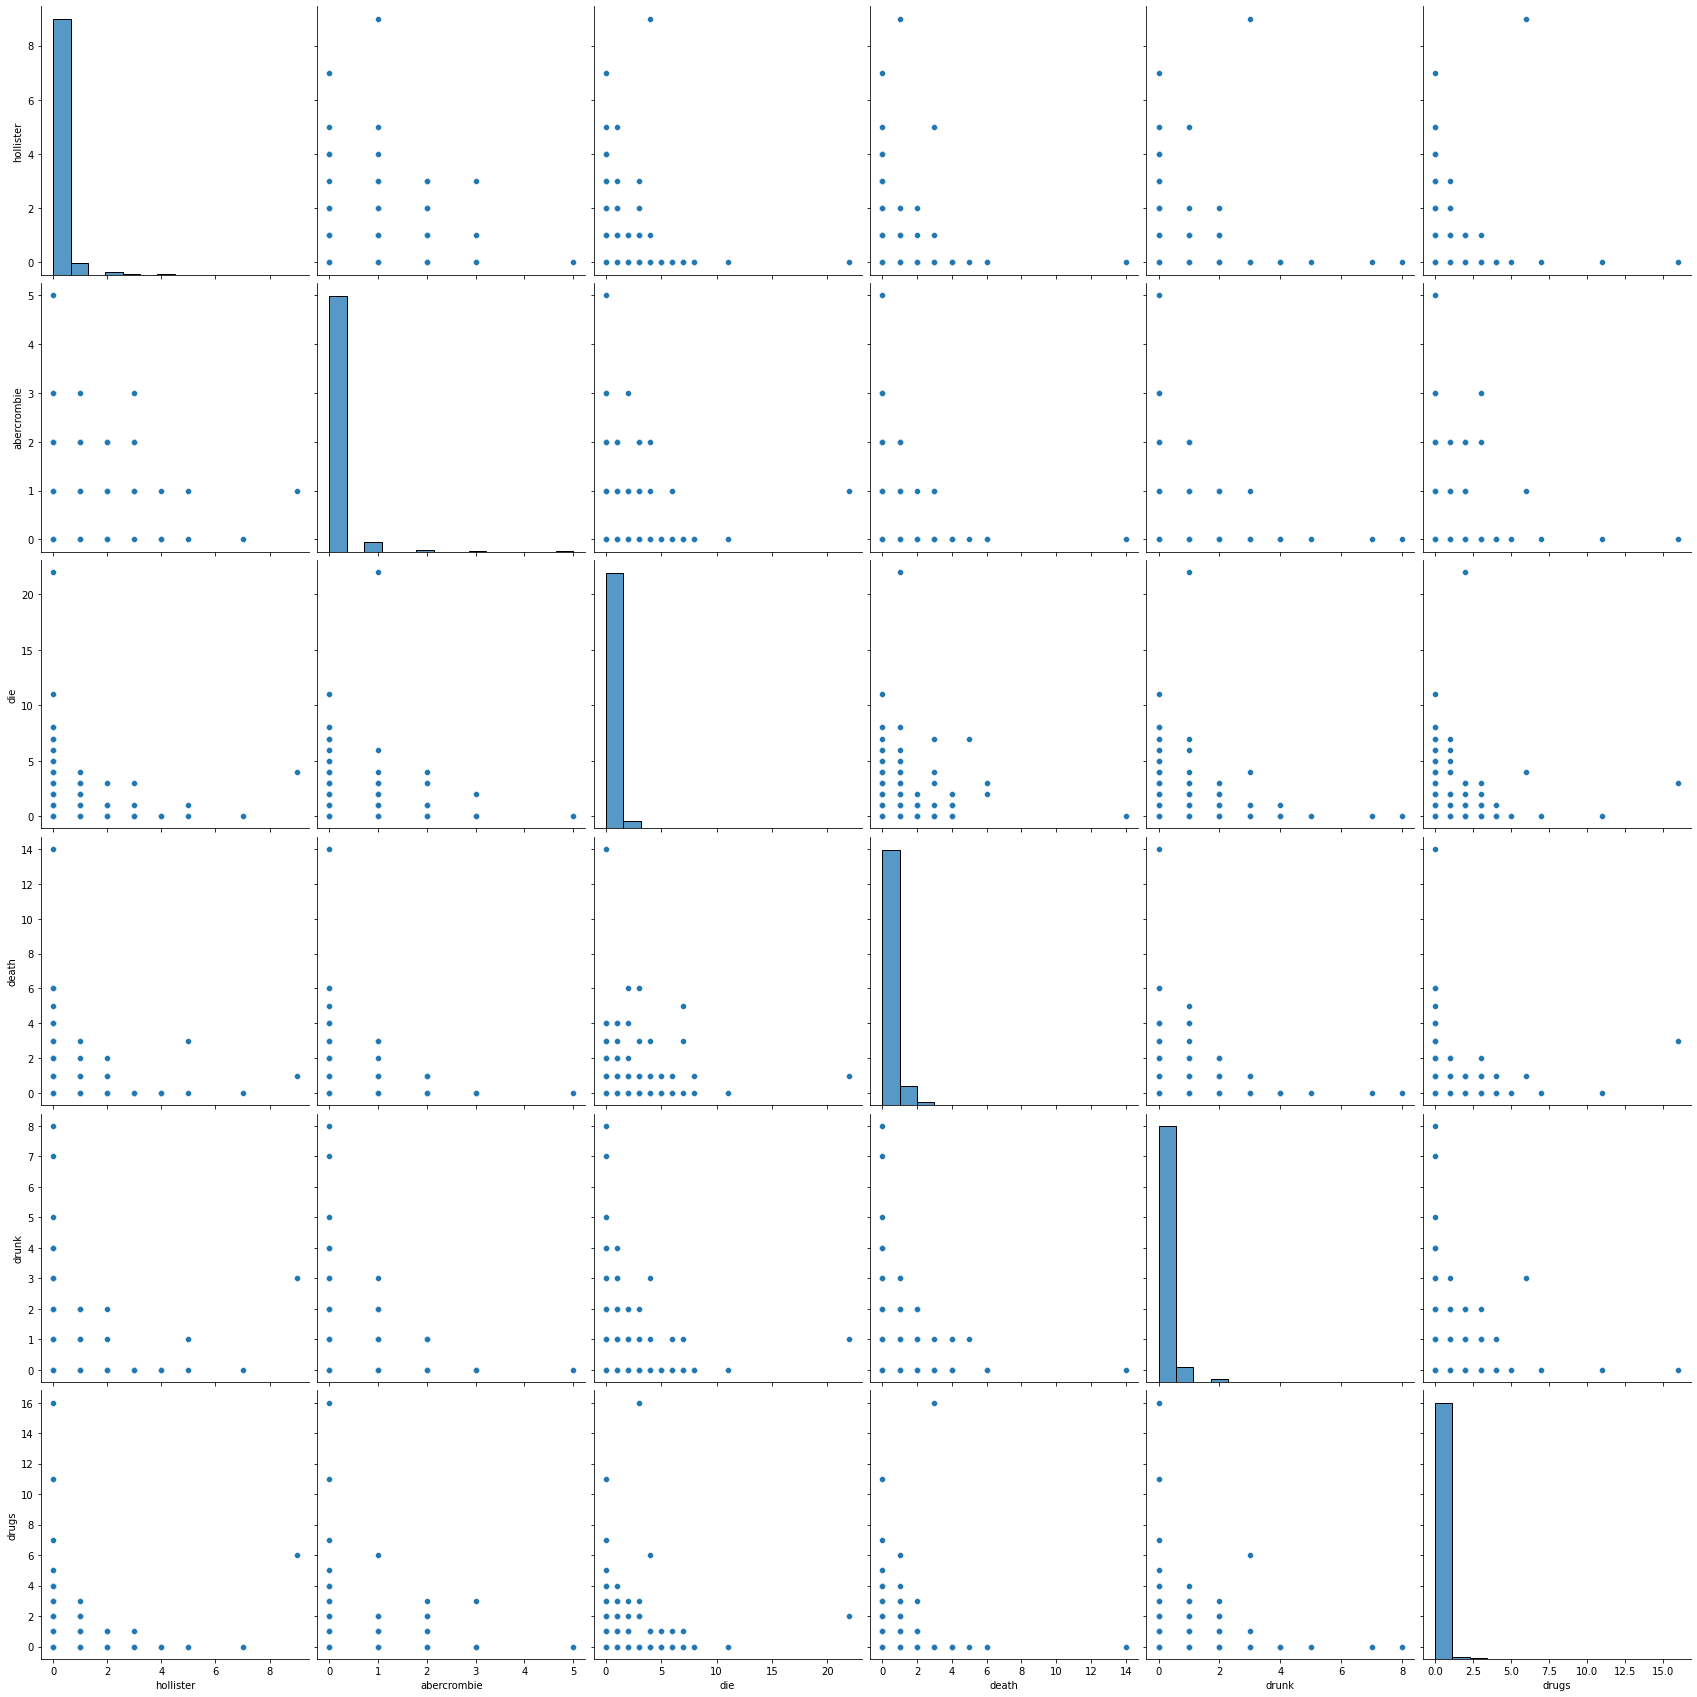

In [7]:
# Explore pair plots for all terms in chunks
fig1 = sns.pairplot(sample[terms].iloc[:,0:5], height=4)
fig2 = sns.pairplot(sample[terms].iloc[:,5:11], height=4)
fig3 = sns.pairplot(sample[terms].iloc[:,11:16], height=4)
fig4 = sns.pairplot(sample[terms].iloc[:,16:21], height=4)
fig5 = sns.pairplot(sample[terms].iloc[:,21:26], height=4)
fig6 = sns.pairplot(sample[terms].iloc[:,26:31], height=4)
fig7 = sns.pairplot(sample[terms].iloc[:,31:38], height=4)

### Process the Data: transform, standardize, or normalize input features

<b><u>Options</u></b>
1. Do nothing, use raw data
2. Z-standardization: subtract the mean of each column and divide by the standard deviation of each column
3. Range standardization: put each variable on a scale from 0 to 1 using function below: $$x' = \frac{x - min(x)}{max(x)-min(x)}$$
4. Standardize each observation so that the rows sum to 1 (represents individual's usage of each word as a proportion of the total number of words they used from list)
5. Log transformation by transforming each column, x, into `log(x + 1)` where 1 is added to the argument to prevent the problem that would be associated with computing `log(0)` which is undefined.

***

We can choose either covariance or correlation PCA for all options EXCEPT option 2 (z-standardization) where both PCAs are identical.

***
I decided to try options 2 and 3.

In [8]:
# Transform the data to give equal importance to all features: 3 ways

# Option 2: StandardScaler for z-standardization
ss = StandardScaler()
ss.fit(df[terms])
df_norm2 = pd.DataFrame(ss.transform(df[terms]), columns=terms)
# scale to standardize data along any axis.... SAME as StandardScaler
x_norm = scale(df[terms])
df_norm2 = pd.DataFrame(x_norm, columns=terms)

# Option 3: MinMaxScaler for range standardization
mms = MinMaxScaler()
mms.fit(df[terms])
df_norm3 = pd.DataFrame(mms.transform(df[terms]), columns=terms)

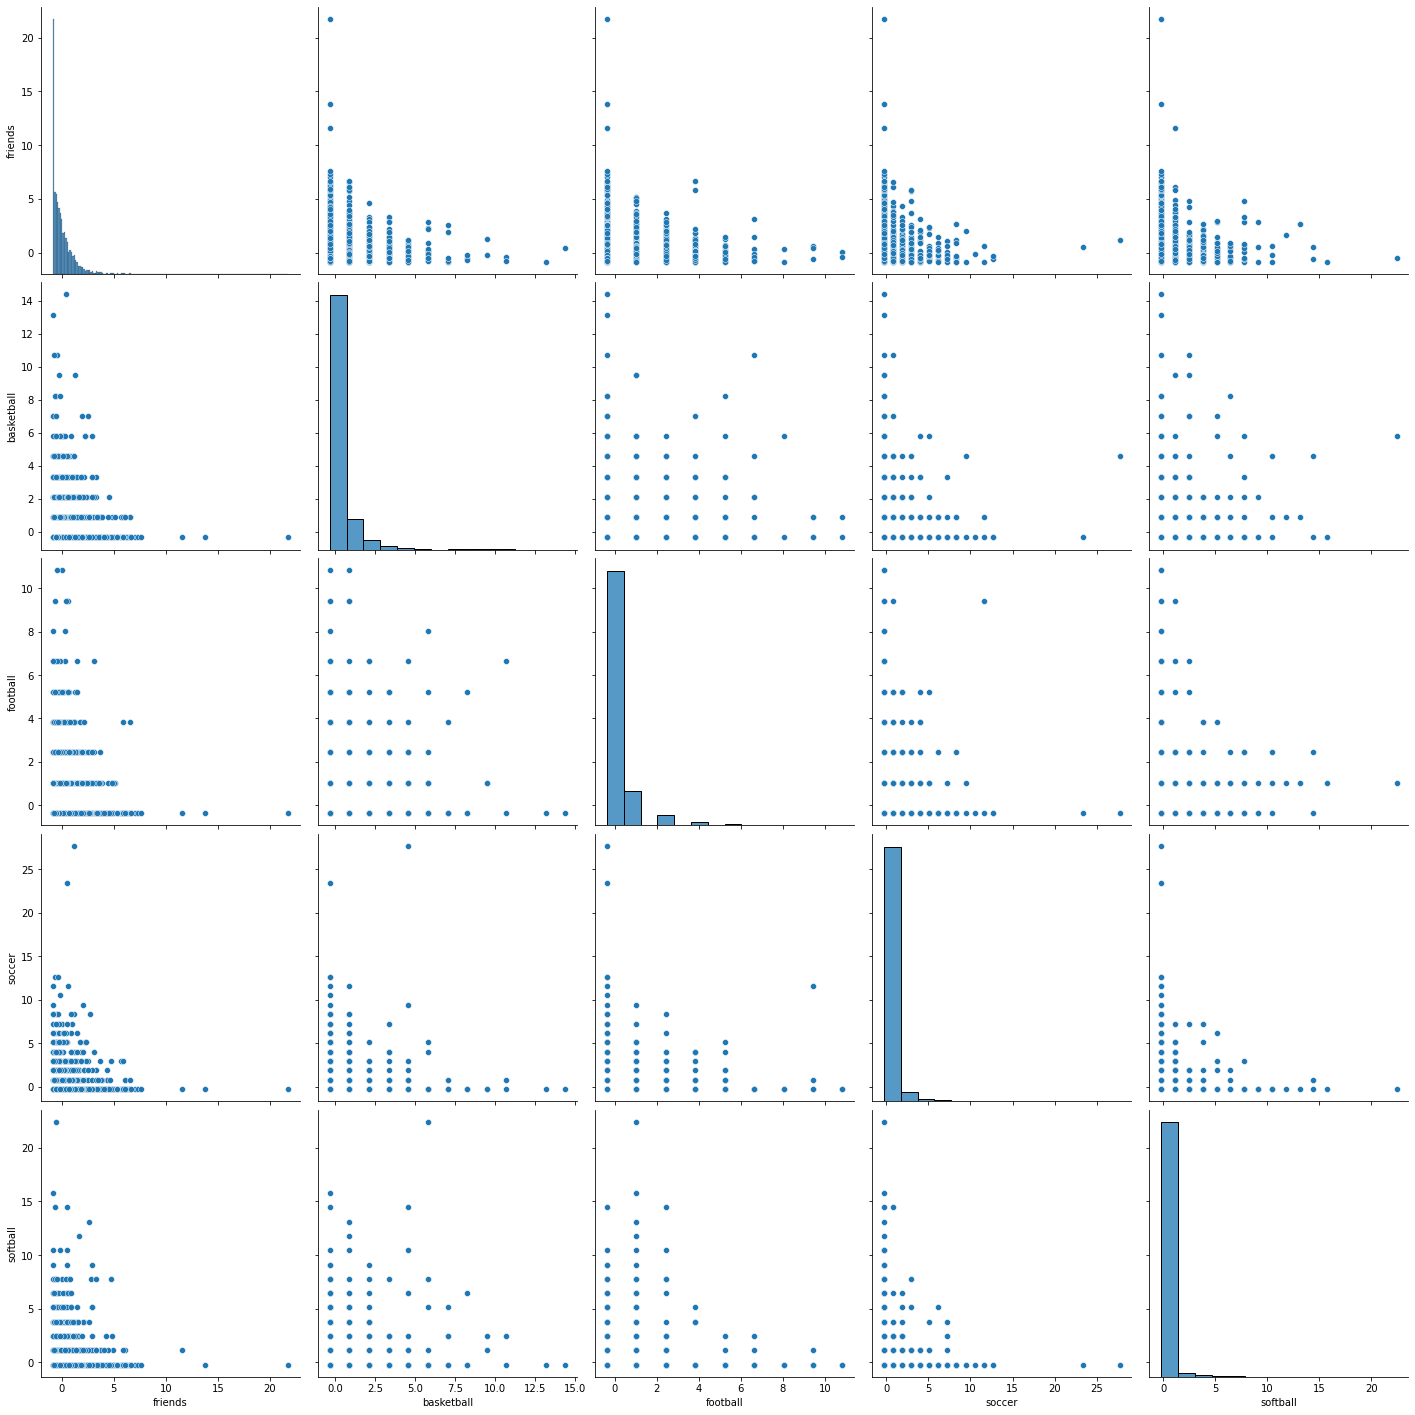

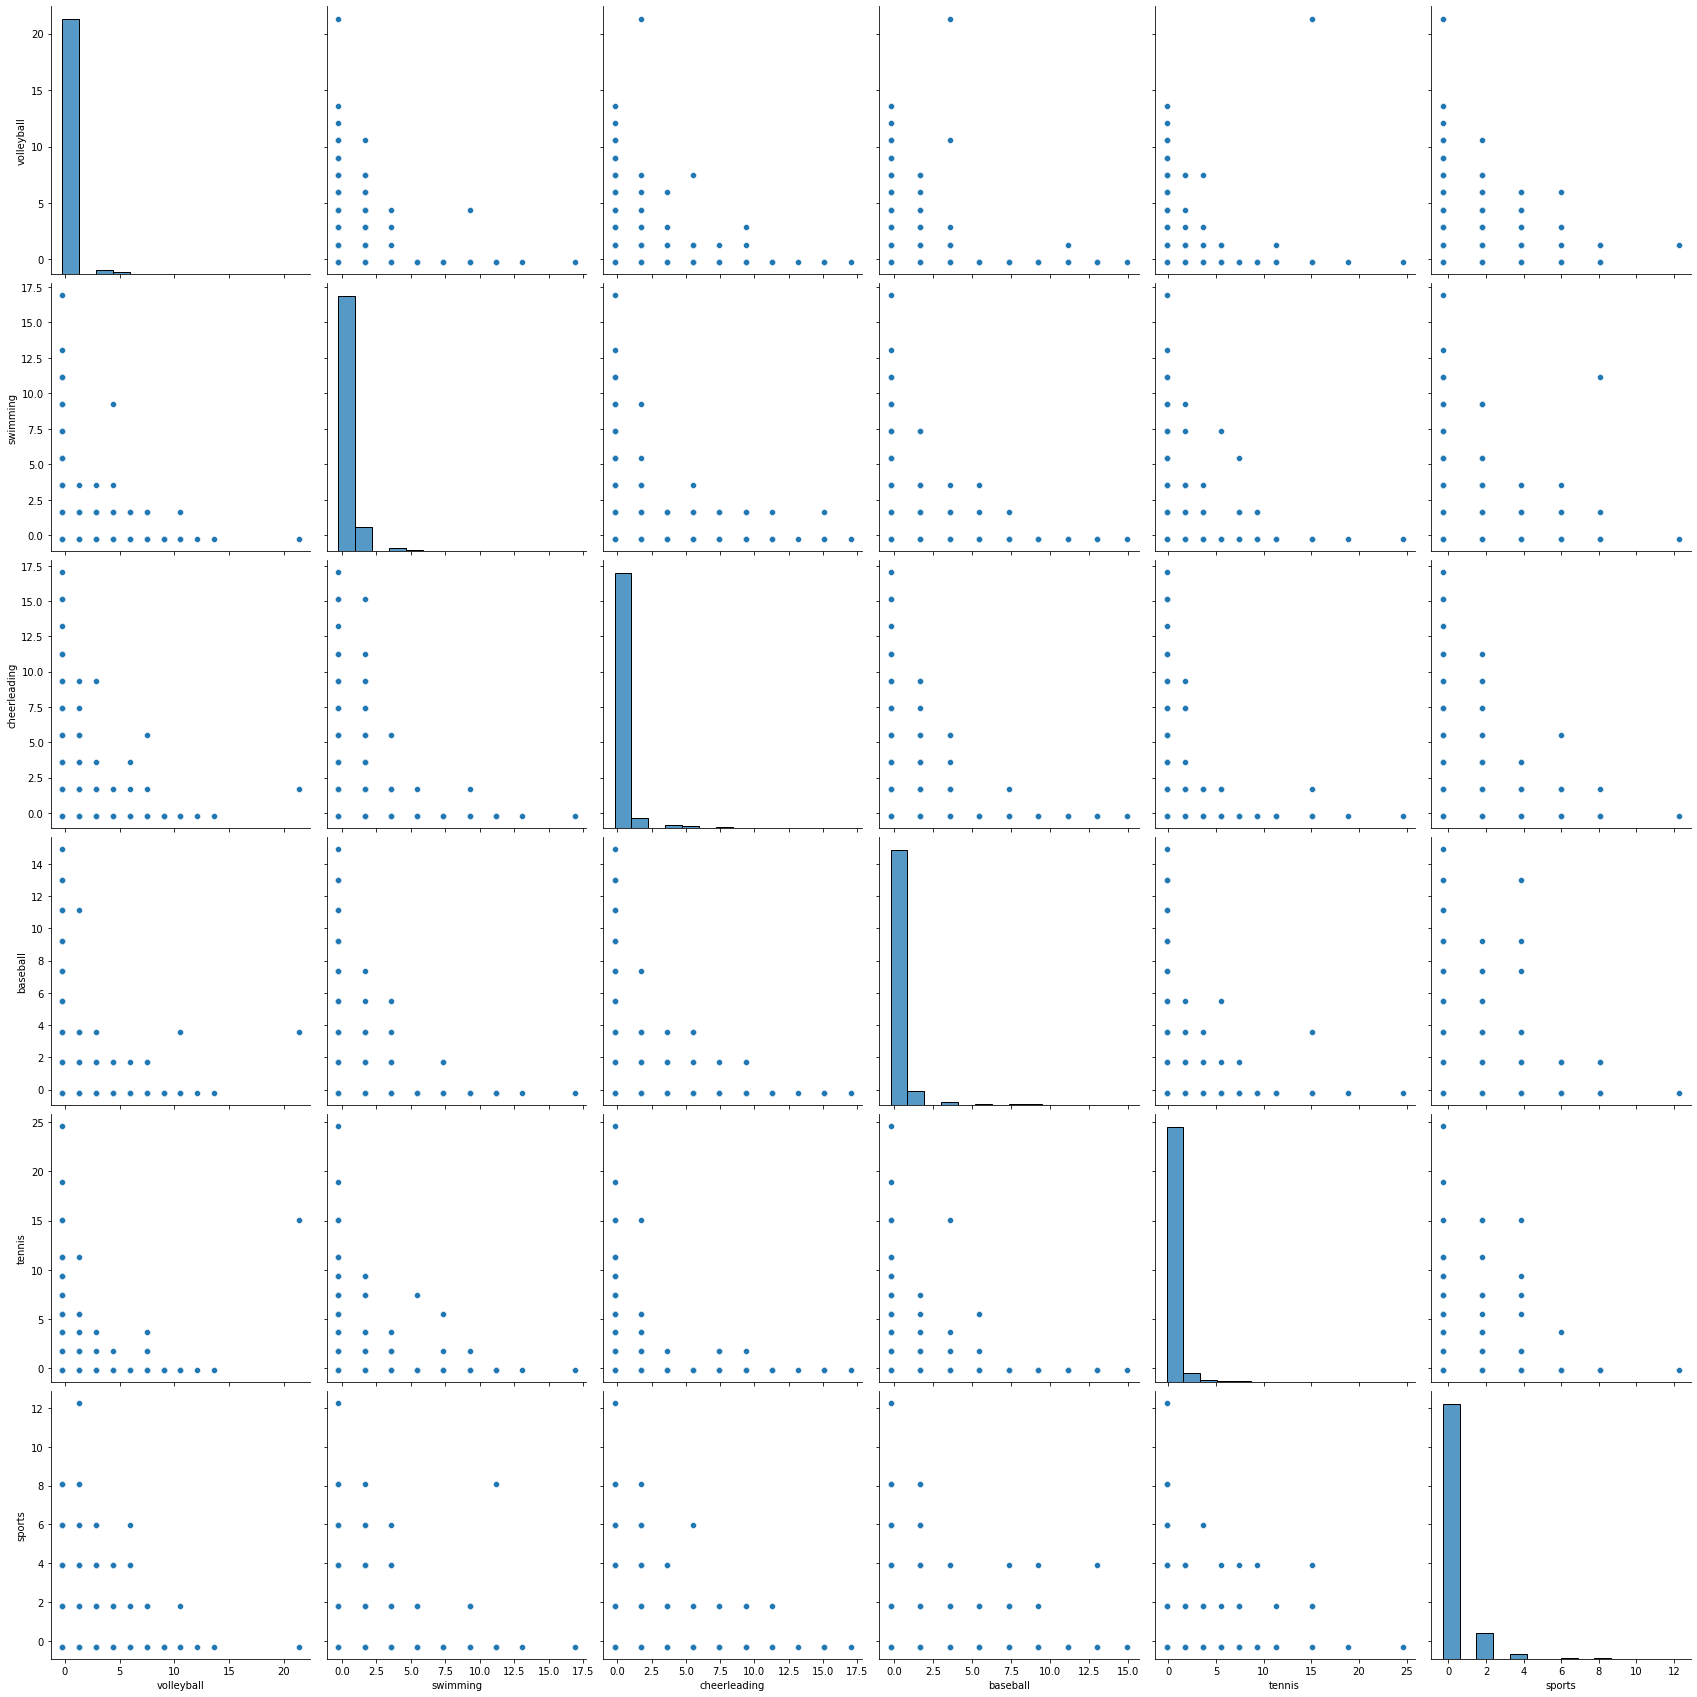

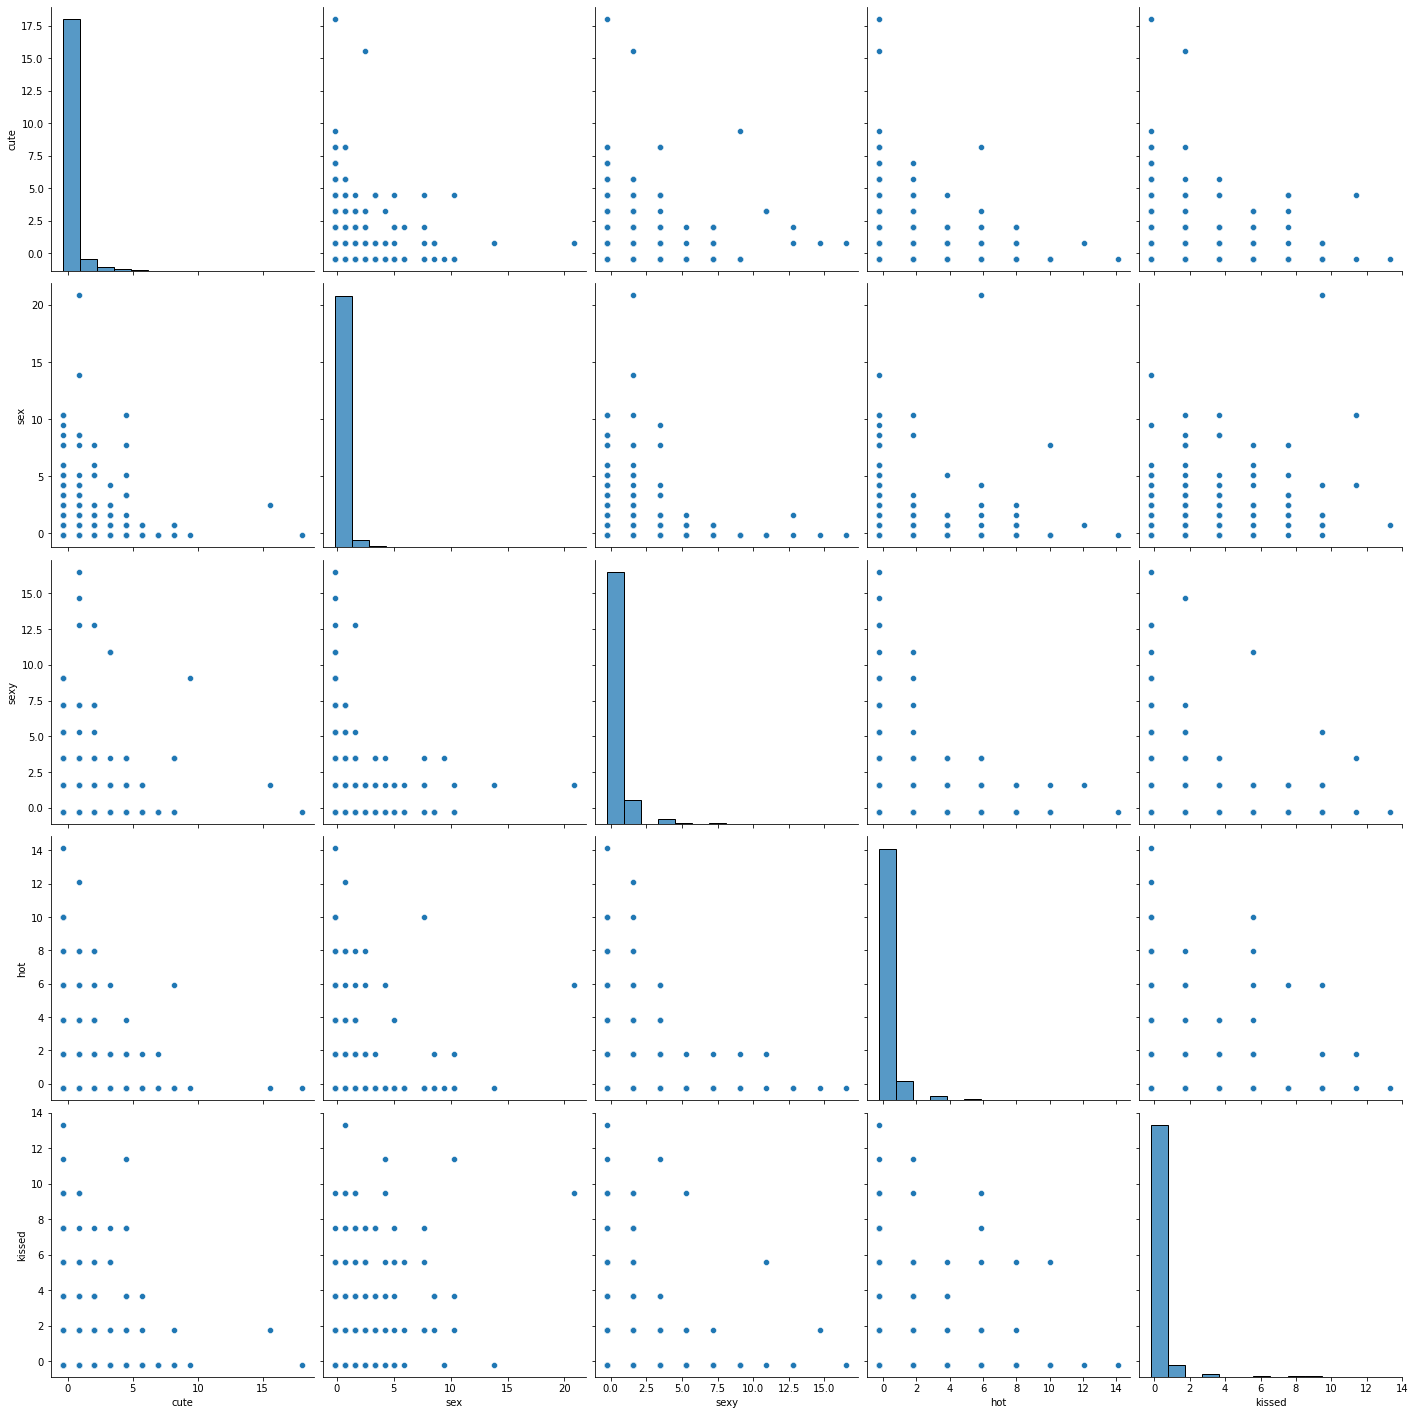

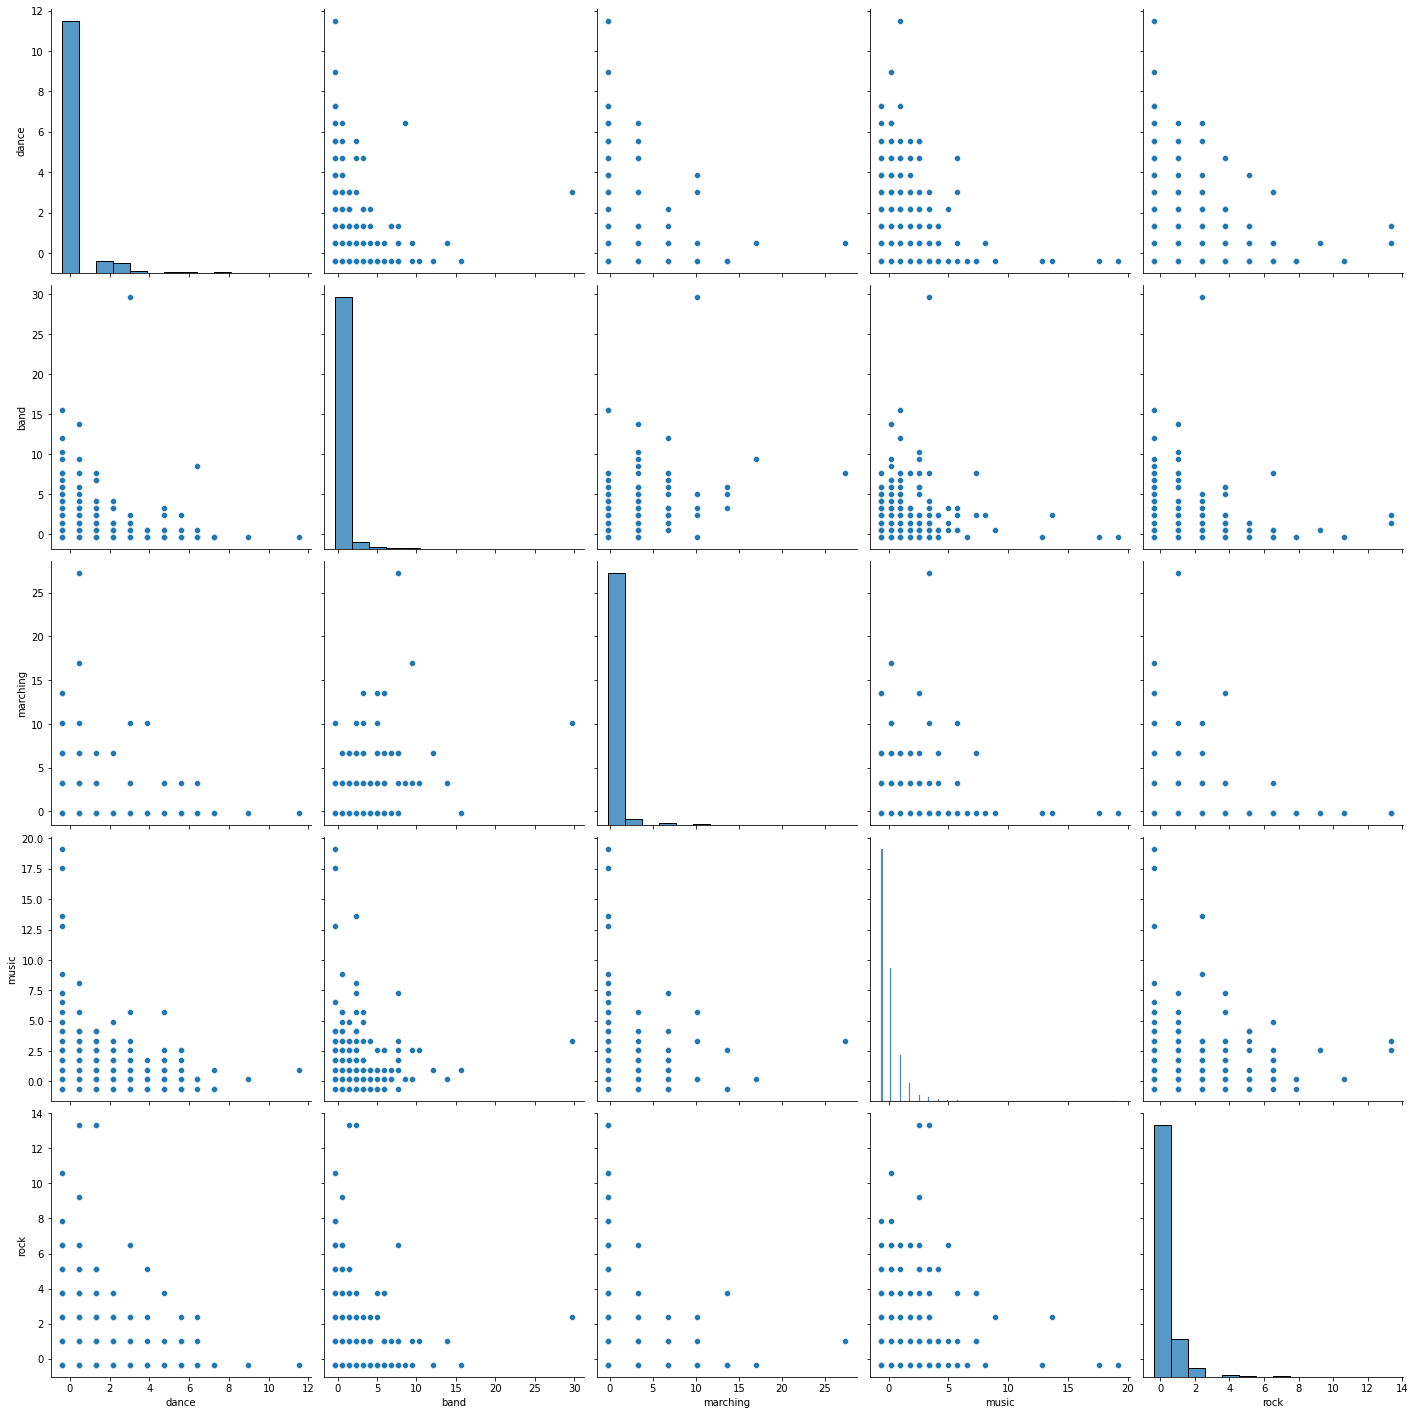

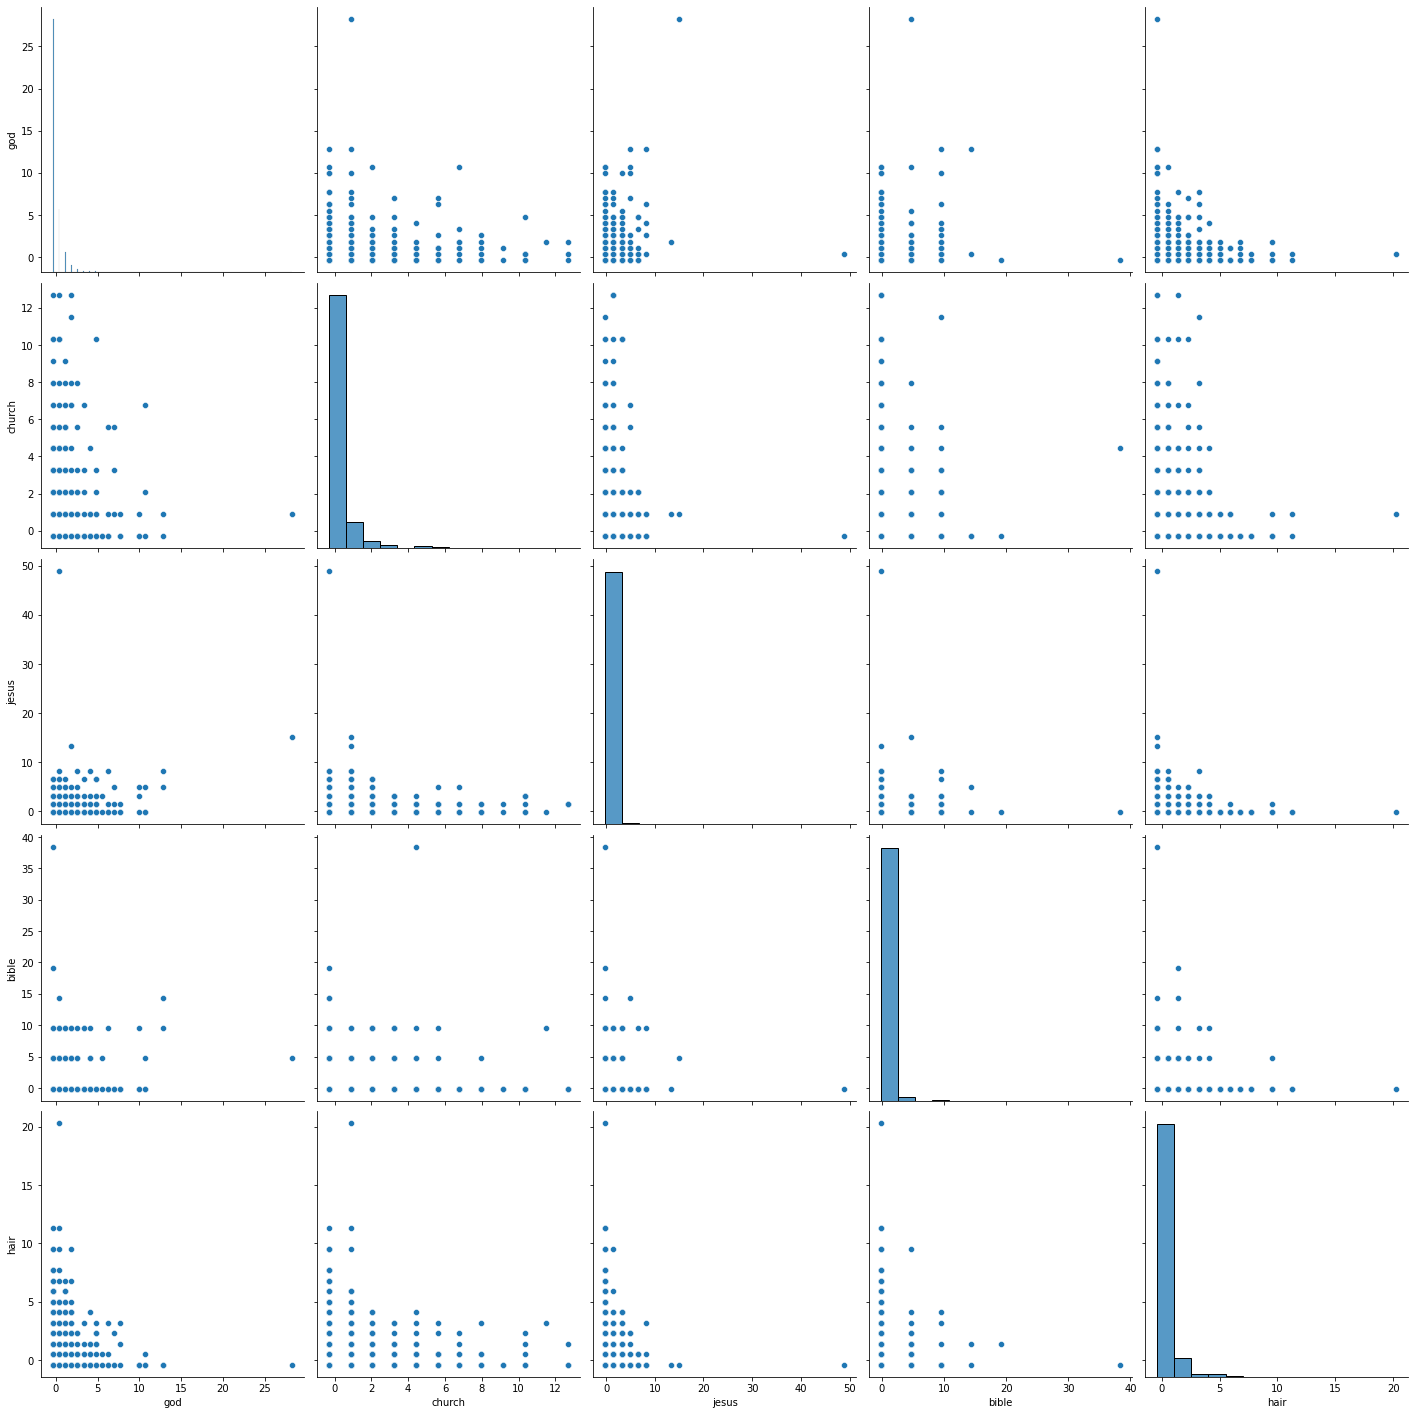

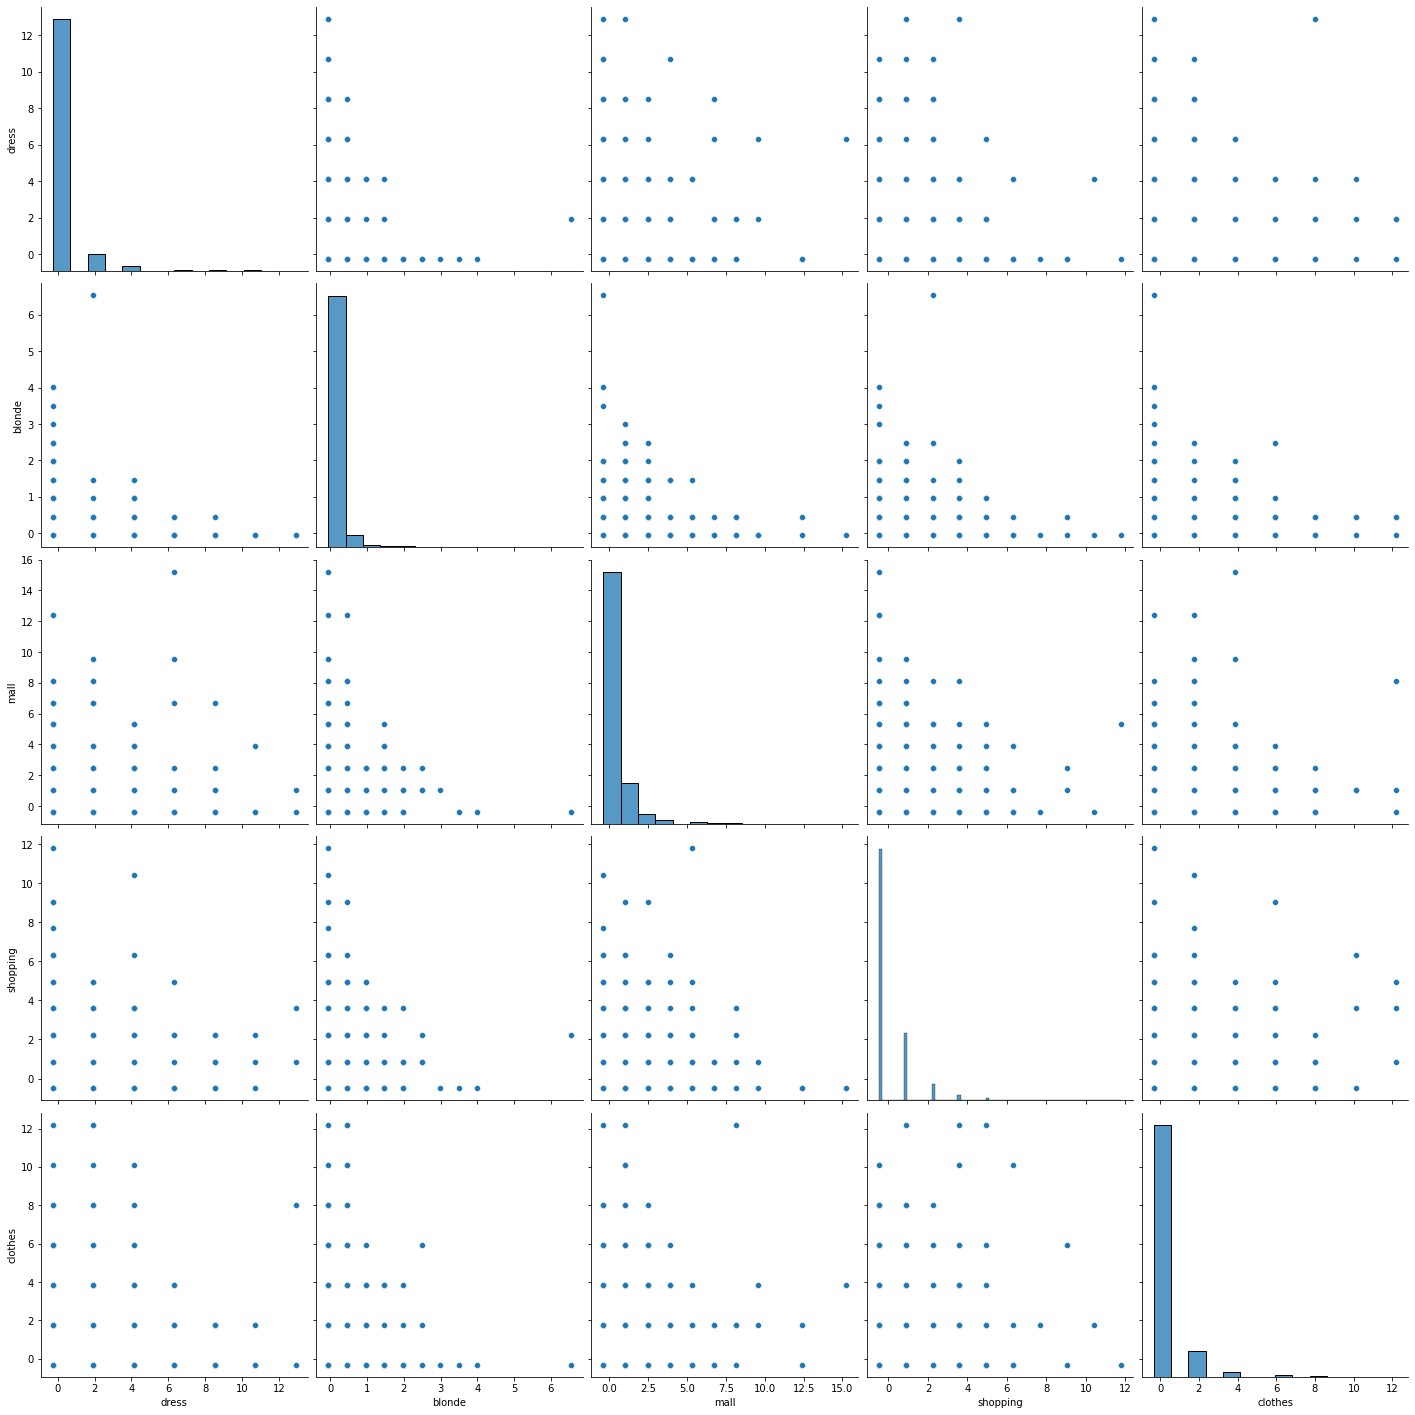

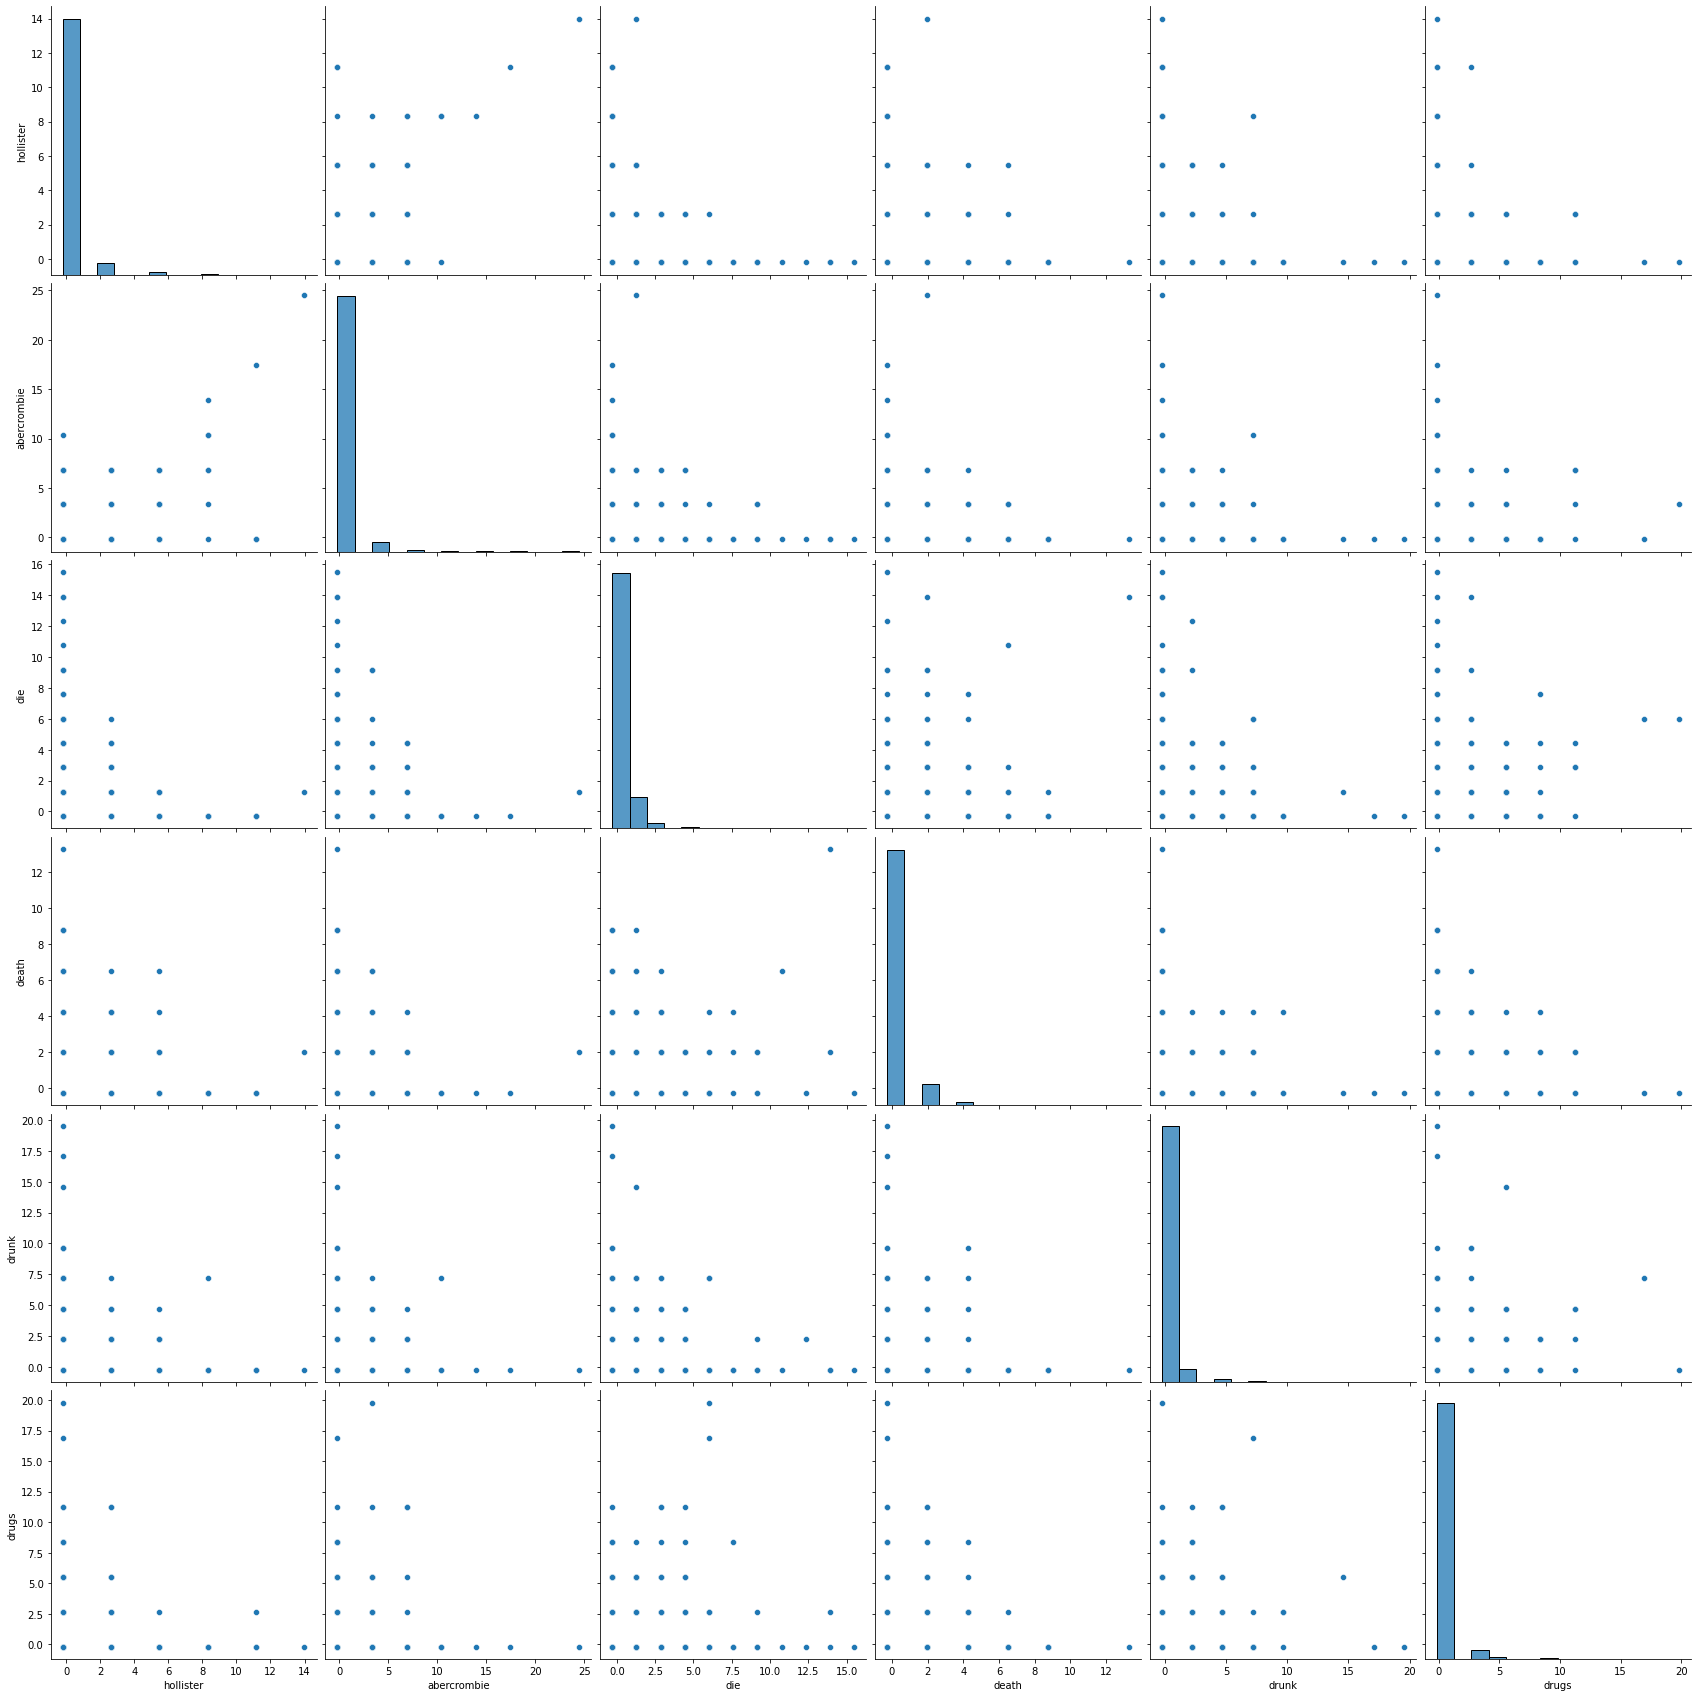

In [9]:
"""Repeat EDA on transformed data to make sure nothing drastic changed
"""
# Set random seed for reproducibility
np.random.seed(7515)

# Get 5000 random indices from 1 to 29074 to downsample obs to 5000 because 30K is a lot to draw
sample_norm = df_norm2.iloc[random.sample(range(29074), 5000)]

# Explore pair plots for all terms in chunks
fig1 = sns.pairplot(sample_norm.iloc[:,0:5], height=4)
fig2 = sns.pairplot(sample_norm.iloc[:,5:11], height=4)
fig3 = sns.pairplot(sample_norm.iloc[:,11:16], height=4)
fig4 = sns.pairplot(sample_norm.iloc[:,16:21], height=4)
fig5 = sns.pairplot(sample_norm.iloc[:,21:26], height=4)
fig6 = sns.pairplot(sample_norm.iloc[:,26:31], height=4)
fig7 = sns.pairplot(sample_norm.iloc[:,31:38], height=4)

### Principle Component Analysis

Perform PCA on a data set using the PCA() class from sklearn. Consider projection onto principal components (using correlation or covariance). We want to better understand the structure of the data cloud in space and to inform any decisions regarding the number of clusters or outliers that could affect the progress of clustering algorithms.
***

There are multiple approaches to PCA. I will show 2 different ways below:

In [10]:
"""Method 1: can be easily re-applied to new data once the projection is calculated"""

# Define number of components to be used for PCA
pca = PCA(n_components=20)

# Step 1: create the PCA model with parameters (calculate loading scores and variation each PC accounts for)
pca_fit = pca.fit(df_norm2)

# Step 2: apply PCA and compute/retrieve the scores (coordinates) values based on loadings and scaled data
scores = pca.transform(df_norm2)
loadings = pca.components_.T

# Convert scores to df
comps = []
for i in range(1,21):
    comps.append("PC{}".format(i))

scores_df = pd.DataFrame(scores, columns=[comps])
loadings_df = pd.DataFrame(loadings, columns=[comps])

loadings_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,0.061626,-0.077231,0.157449,0.067156,0.056408,-0.110727,-0.060631,0.295978,0.005152,0.001866,0.065486,0.062139,-0.690295,-0.158561,-0.015282,0.466525,0.004055,0.084108,-0.122222,0.089597
1,0.131738,-0.092969,0.144916,0.244062,-0.322323,0.001228,-0.088243,0.105630,-0.042437,-0.090693,-0.062671,-0.131840,0.034434,-0.007942,0.016430,-0.048673,-0.046048,-0.090100,-0.006972,-0.186654
2,0.140619,-0.079411,0.099150,0.256996,-0.271983,0.025900,0.286273,0.005603,-0.139240,0.157107,-0.198769,-0.096192,0.076237,-0.091980,-0.077167,-0.095807,0.246516,-0.031861,-0.113641,-0.043077
3,0.061991,-0.060255,0.067194,0.105080,-0.134335,0.033783,0.060523,-0.153802,0.306450,0.243702,0.290004,0.017025,-0.040088,-0.503919,0.527059,-0.186385,-0.191686,0.020965,0.082202,-0.051871
4,0.074227,-0.065879,0.104614,0.163774,-0.194293,-0.007716,-0.391934,0.301926,-0.055577,-0.212798,0.032429,0.076372,0.057501,0.119152,0.074997,0.019900,-0.197840,0.250229,0.368535,0.179321


In [11]:
"""Method 2: can be easily re-applied to new data once the projection is calculated"""

# Do Step 1 and Step 2 combined; project the original data into the PCA space-- good to use for SINGLE dataset
scores = pca.fit_transform(df_norm2)
loadings = pca.components_.T

# Convert scores to df
comps = []
for i in range(1,21):
    comps.append("PC{}".format(i))

scores_df = pd.DataFrame(scores, columns=[comps])
loadings_df = pd.DataFrame(loadings, columns=[comps])

scores_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,-1.507704,-0.004807,-0.454658,-0.412551,0.015921,0.061750,-0.037861,-0.127197,-0.252459,-0.000261,-0.241870,0.514655,-0.073498,-0.313149,-0.065256,0.195698,0.083616,0.089262,0.316605,-0.045239
1,3.352108,-0.212803,-0.840724,-0.178224,0.624531,-2.756396,-0.488891,-1.992538,-0.167609,-0.371390,-2.851290,2.627115,-0.002492,-1.344051,3.040933,0.528947,-1.538321,-3.524883,-1.237606,2.238464
2,-0.626561,0.633250,-0.539664,0.721429,0.340792,0.309945,0.729521,0.804712,0.565322,-0.044978,-0.981319,-0.801277,-0.164836,0.489143,-0.219909,0.167657,0.106548,-0.090830,-0.812195,0.235619
3,-1.118853,0.023604,-0.557083,-0.321569,-0.062671,-0.225216,0.301623,-0.464298,-0.064103,-0.195341,-0.036042,0.308652,0.382409,0.073887,0.233691,-0.552550,-0.386481,0.070772,0.096709,0.054234
4,4.229410,1.361021,-3.322636,-1.959319,-0.136142,1.225343,-2.487856,-1.284105,-2.120754,1.073833,2.137983,-0.558734,-0.071794,-2.209175,0.445975,1.115436,-0.381678,0.738657,-0.796169,-0.014085


In [12]:
# Other parts to PCA
eigenvectors = pca.components_
eigenvalues = pca.explained_variance_

# Explained Variance per PC
explained_variance = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_variance = np.cumsum(np.round(explained_variance, decimals=3))

# Combine df of PC, explained variance, cumulative variance
pc_df = pd.DataFrame(comps, columns=['PC'])
explained_variance_df = pd.DataFrame(explained_variance, columns=['Explained Variance'])
cumulative_variance_df = pd.DataFrame(cumulative_variance, columns=['Cumulative Variance'])
df_explained_variance = pd.concat([pc_df, explained_variance_df, cumulative_variance_df], axis=1)

df_explained_variance.head()

,PC,Explained Variance,Cumulative Variance
0,PC1,0.088295,0.088
1,PC2,0.046504,0.135
2,PC3,0.044022,0.179
3,PC4,0.040659,0.220
4,PC5,0.039605,0.260


### Determine Input Data: Reduce Dimensionality Before Clustering
- Considering all <b>5</b> methods of data transformation, there are <b>9</b> different options of matrix factorizations using PCA (corr or cov) to choose from
- Number of PCs can be chosen based upon `screeplot` or `cumulative % variance explained`.

7

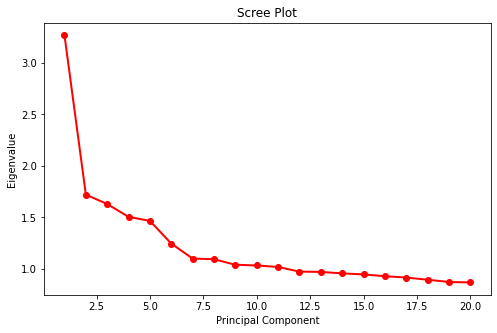

In [13]:
# See scree plot --> first 7 PCs seem useful
fig = plt.figure(figsize=(8,5))
PC_vals = np.arange(20) + 1
plt.plot(PC_vals, pca.explained_variance_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')

# identify the elbow point programmatically with kneed package
scree = KneeLocator(PC_vals, pca.explained_variance_, curve="convex", direction="decreasing")
scree.elbow

In [14]:
# Reduce data dimension to 7 PCs
reduced_pca = PCA(n_components=7)
reduced_data = reduced_pca.fit_transform(df_norm2)

reduced_data = pd.DataFrame(reduced_data)
reduced_data.head()

,0,1,2,3,4,5,6
0,-1.507983,-0.012322,-0.427854,-0.447309,0.026938,0.005693,-0.072519
1,3.354479,-0.068523,-0.999390,-0.152556,0.856437,-1.310539,-1.275257
2,-0.628417,0.634541,-0.543456,0.754637,0.311193,0.233646,0.779277
3,-1.118819,-0.003916,-0.580357,-0.329336,-0.021504,0.089288,0.243895
4,4.217094,1.266122,-3.279637,-2.026530,-0.409604,0.321316,-2.537808


### Determine Number of Clusters, <i>k</i>

<u><b>Common Methods</b></u>
1. Look at `screeplot` (9 different options)
2. Examine the `SSE value` for clustering with k = 1, 2, 3,... and look for an elbow in that graph
3. Compute the `trace(Wq)` for various numbers of clusters. This should always decrease (or remain constant) as the number of clusters grows, and we use the maximum of the second differences to determine the number of clusters (i.e. where the slope of the curve is increasing the fastest) $$W_q=\sum_{k=1}^q \sum i ε C_k (x_i - c_k)(x_i - c_k)^T $$ <br>
4. Compute `Marriot Index`. Let Wq be the within-group dispersion matrix for data clustered into q clusters, as defined in the equation from method 3. Look for the maximum difference between successive levels to determine the optimal k: $$q^2 det (W_q)$$<br>
5. Method of `Friedman and Rubin`. Look for the maximum difference in values of this criterion to determine the optimal k: $$trace(W_q^{-1} B_q)$$<br> where $$B_q = \sum_{k=1}^q n_k (c_k - xbar) (c_k - xbar)^T$$ <br>
6. Use the `Gap Statistic` (too slow for 30K+ observations).
7. Use the average `Silhouette value` (too slow for 30k+ rows requires storage of pairwise distance matrix). For each observation, the silhouette value of that observation is: $$ \frac{b(i) - a(i)}{max(a(i),b(i))} $$

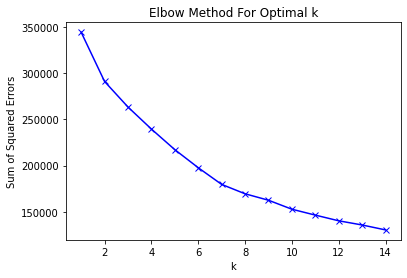

7

In [15]:
# I decided to go with method 2 and followed steps by Tola Alade using link below
# https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f

"""Initialize k-means for 1-15 clusters and use the inertia attribute to identify 
the sum of squared error of samples to the nearest cluster centre"""

# list holds the SSE values for each k
sse = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k) # initialize k-means
    km = km.fit(reduced_data) # compute k-means clustering
    sse.append(km.inertia_) # append SSE of samples to their closest cluster center
    

"""As k increases, the sum of squared error approaches zero. 
If we set k to its maximum value n (where n is number of samples) each 
obs will form its own cluster meaning sum of squared error equals zero.
"""

# Plot of sum of squared errors for k in the range specified above. The elbow shows the optimal k.    
plt.plot(K, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Errors')
plt.title('Elbow Method For Optimal k')
plt.show()

# identify the elbow point programmatically with kneed package
kl = KneeLocator(range(1, 15), sse, curve="convex", direction="decreasing")
kl.elbow # suggests 7 clusters

In [16]:
# Create KMeans estimator class with specified parameters before fitting the estimator to the data
kmeans_model = KMeans(n_clusters=7, init = 'random', max_iter=10)

# Fit Kmeans class to the transformed data (performs 10 runs of the k-means algorithm on your data by default)
kmeans_model.fit(reduced_data)

# Add newly assigned clusters to df
df['cluster'] = pd.Series(kmeans_model.labels_)

In [17]:
# See frequency count of clusters
df['cluster'].value_counts()

4.0    18590
5.0     4359
1.0     2145
0.0      993
2.0      871
3.0      624
6.0      583
Name: cluster, dtype: int64

In [18]:
cluster1 = df[df['cluster']==1]
cluster2 = df[df['cluster']==2]
cluster3 = df[df['cluster']==3]
cluster4 = df[df['cluster']==4]
cluster5 = df[df['cluster']==5]
cluster6 = df[df['cluster']==6]
cluster7 = df[df['cluster']==7]

clusters = [cluster1, cluster2, cluster3, cluster4, cluster5, cluster6, cluster7]
n = 0

for cluster in clusters:
    top5 = cluster[terms].sum().sort_values(ascending=False).index[:5].tolist()
    n += 1
    print(f"top terms for cluster {n}: ", top5)

top terms for cluster 1:  ['friends', 'music', 'dance', 'god', 'hair']
top terms for cluster 2:  ['friends', 'music', 'dance', 'hair', 'god']
top terms for cluster 3:  ['friends', 'music', 'god', 'dance', 'hair']
top terms for cluster 4:  ['friends', 'music', 'god', 'hair', 'dance']
top terms for cluster 5:  ['friends', 'music', 'god', 'dance', 'hair']
top terms for cluster 6:  ['friends', 'music', 'god', 'dance', 'shopping']
top terms for cluster 7:  ['drugs', 'band', 'kissed', 'hot', 'sexy']


There are a lot of overlap in terms for clusters (e.g. "friends", "music", "dance", "god" appear in 6 of the clusters as top terms), so we can try removing these terms to see if we get more variation in top terms for the next phase.

### Profile the Clusters

- Option 1: Visualize variable distributions, cluster vs. all
- Option 2: Decision Trees to Predict Cluster

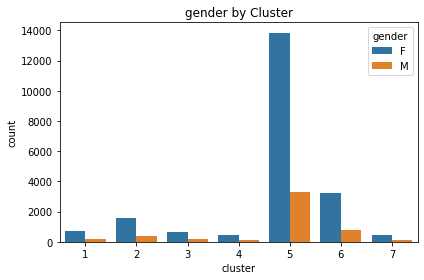

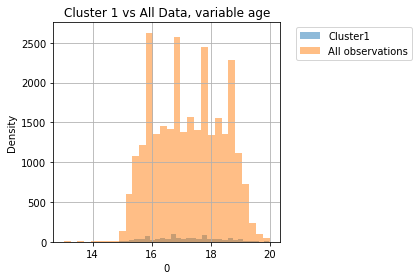

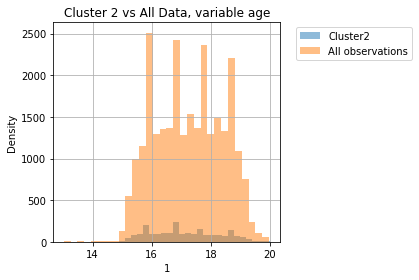

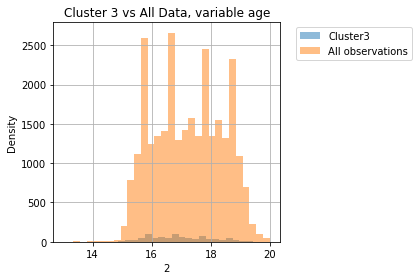

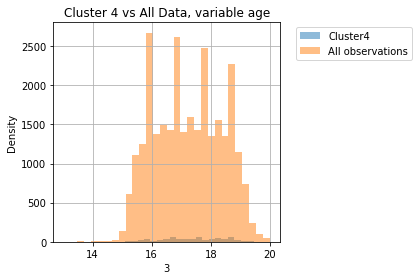

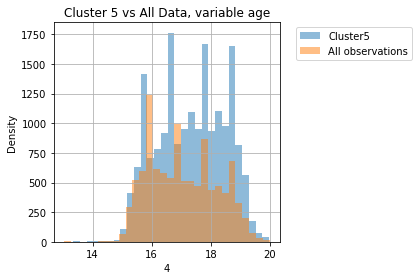

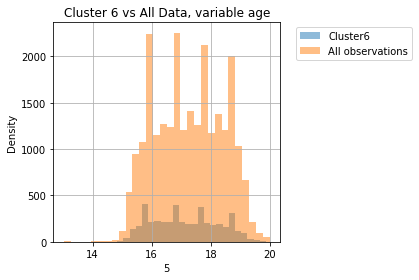

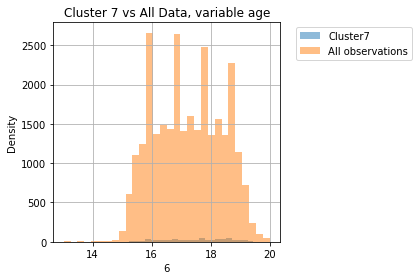

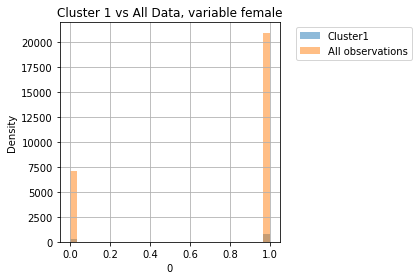

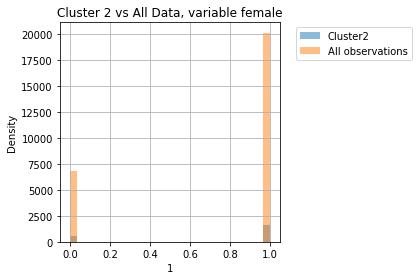

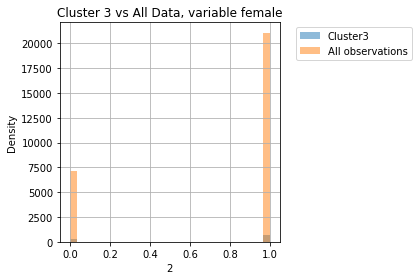

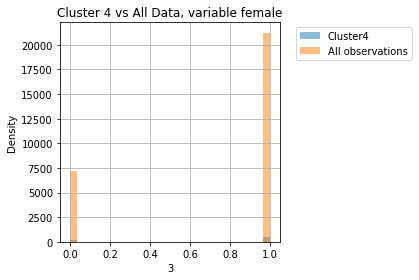

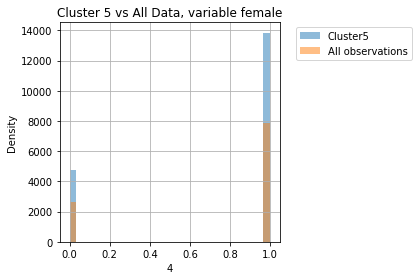

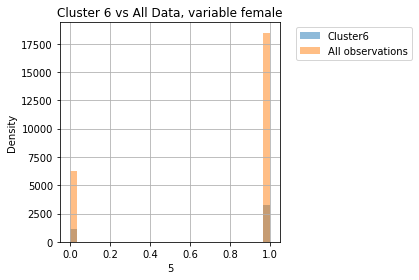

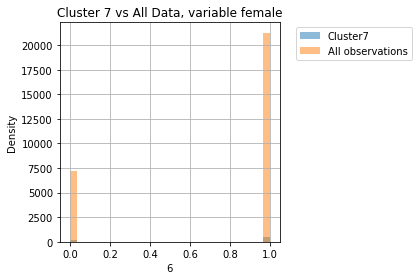

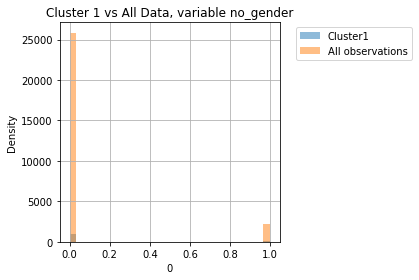

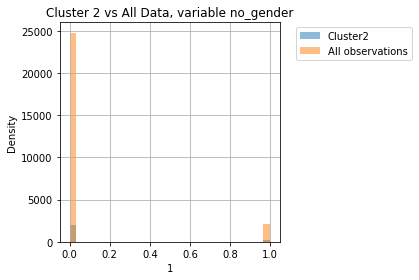

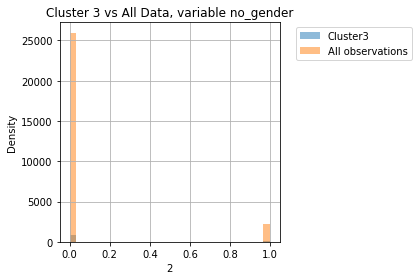

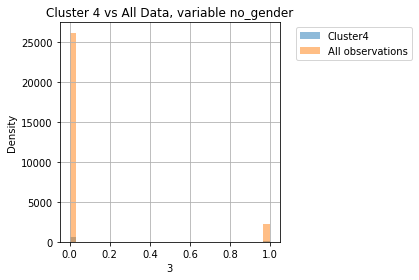

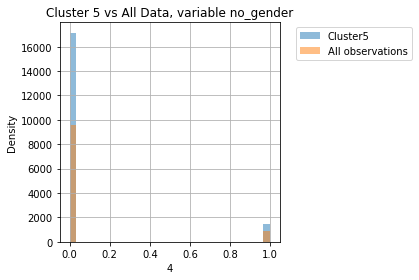

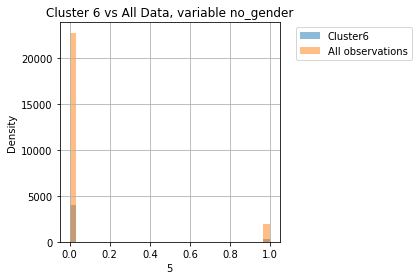

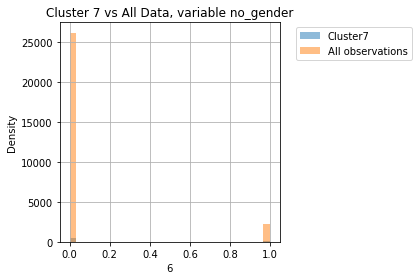

In [19]:
""" Option 1:
    custom function to see variable distributions for cluster vs. all observations
"""

def clusterProfile(df, clusterVar, varsToProfile):
    
    # Assign max cluster number to k
    k = int(df[clusterVar].max())
    
    # Loop through demographic vars and check variable type
    for i in varsToProfile:
        
        # if numeric, make histogram
        if df[i].dtypes==np.number:
            for j in range(0, k+1):
                df[df[clusterVar]==j][i].hist(alpha=0.5, bins=30, label=f'Cluster{j+1}')
                df[df[clusterVar]!=j][i].hist(alpha=0.5, bins=30, label='All observations')
                plt.title(f'Cluster {j+1} vs All Data, variable {i}')
                plt.xlabel(j)
                plt.ylabel('Density')
                plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
                plt.tight_layout()
                plt.show()
                
        # if categorical, make bar chart of level frequency
        if (df[i].dtypes.name == 'category') & (len(df[i].unique()) < 5):
            ax = sns.countplot(x="cluster", hue=i, data=df)
            ax.set_xticklabels([1, 2, 3, 4, 5, 6, 7])
            plt.title(f'{i} by Cluster')
            plt.tight_layout()
            plt.show()
            
        # Next phase: make plots as subplots
        
clusterProfile(df, 'cluster', demographics)        

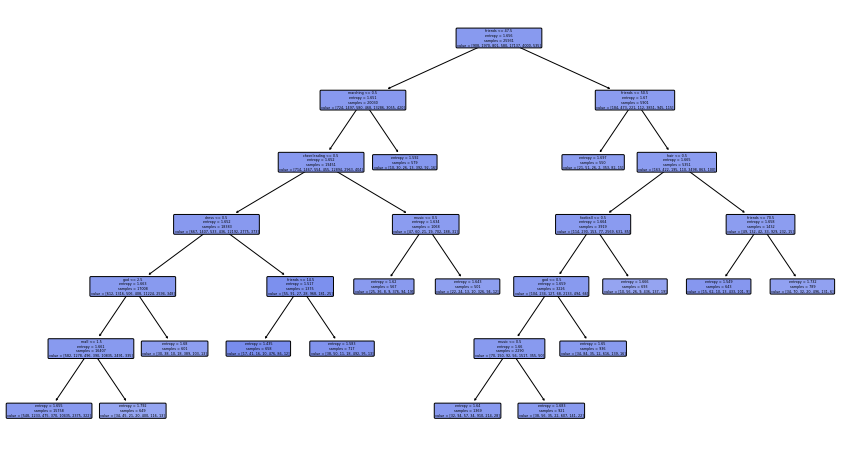

In [20]:
""" Option 2:
    Decision Trees to Predict Cluster
"""
# Drop nulls; assign predictors and target
df = df.dropna()
predictors = df[terms]
target = df['cluster']

# Build preliminary decision tree
dtree = DecisionTreeClassifier(min_samples_leaf=500, max_depth=6, criterion='entropy')
dtree.fit(predictors, target)

# Plot tree
plt.figure(figsize=(15, 8))

# Pass tree from training data to sklearn plot_tree() with parameters making it easier to look at
plot_tree(dtree,
         filled = True,
         rounded = True,
         feature_names = predictors.columns);